1. Given the datasets shown in Table.1, Create a database fitbit.db using Sqlite and
perform the following.

In [1]:
pip install xgboost

In [ ]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor as rf_sk
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
import pyspark
from pyspark.ml.regression import RandomForestRegressor as rf_sp
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

sns.set(rc={'figure.figsize': (10, 6)})
sns.set_style('whitegrid')
sns.set_palette('Set2')

In [ ]:
%cd D:\PDA_RAR_sqlite\data

D:\PDA_RAR_sqlite\data


In [ ]:
path = 'D:\\PDA_RAR_sqlite\\data'
full_path_list = [ path + '/' + f for \
                 f in os.listdir(path) if os.path.isfile(os.path.join(path,f)) ]

In [ ]:
# The fitbit dataset is inclusive of hours and minutes datasets as well. However, for the purpose of this exercise,
# it is chosen to analyze daily aggregated data only.

# connect to sql db
con = sql.connect("fitbit.db")
cur = con.cursor()

def get_table_name(full_path_list, i):
    return full_path_list[i].split("/")[-1].split('.')[0]

pbar = tqdm(total=len(full_path_list), desc='[Loading Data...]')
for i in range(0,len(full_path_list)):
    pd.read_csv(full_path_list[i]).to_sql(get_table_name(full_path_list, i), con, if_exists='append', index=False)
    pbar.update(1)
pbar.close()

[Loading Data...]: 100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.72it/s]


In [ ]:
# simple sql query test
df = pd.read_sql(f'SELECT * FROM {get_table_name(full_path_list, 0)}', con)
df.head()

Id ActivityDate  TotalSteps  TotalDistance  TrackerDistance  \
0  1503960366    4/12/2016       13162           8.50             8.50   
1  1503960366    4/13/2016       10735           6.97             6.97   
2  1503960366    4/14/2016       10460           6.74             6.74   
3  1503960366    4/15/2016        9762           6.28             6.28   
4  1503960366    4/16/2016       12669           8.16             8.16   

   LoggedActivitiesDistance  VeryActiveDistance  ModeratelyActiveDistance  \
0                       0.0                1.88                      0.55   
1                       0.0                1.57                      0.69   
2                       0.0                2.44                      0.40   
3                       0.0                2.14                      1.26   
4                       0.0                2.71                      0.41   

   LightActiveDistance  SedentaryActiveDistance  VeryActiveMinutes  \
0                 6.06                      0.0                 25   
1                 4.71                      0.0                 21   
2                 3.91                      0.0                 30   
3                 2.83                      0.0                 29   
4                 5.04                      0.0                 36   

   FairlyActiveMinutes  LightlyActiveMinutes  SedentaryMinutes  Calories  
0                   13                   328               728      1985  
1                   19                   217               776      1797  
2                   11                   181              1218      1776  
3                   34                   209               726      1745  
4                   10                   221               773      1863

In [ ]:
# list all tables
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()
print(f'Total of {len(tables)} tables in database.')

Total of 8 tables in database.


In [ ]:
# check for sample data and data size
fitbit_df = pd.read_sql(f'SELECT * FROM fitbit_df', con)

print(len(fitbit_df))

fitbit_df.head()

413


SedentaryMinutes  TotalSteps  TotalMinutesAsleep  TotalTimeInBed  Calories
0               728       13162                 327             346      1985
1               776       10735                 384             407      1797
2               726        9762                 412             442      1745
3               773       12669                 340             367      1863
4               539        9705                 700             712      1728

In [ ]:
#1) perform exploratory analysis
# Average Calories, Steps and Distance by Id and by day of the week
query = """
SELECT
	ROUND(AVG(Calories),2) AS avg_calories,
	ROUND(AVG(TotalSteps),2) AS avg_steps,
	ROUND(AVG(TotalMinutesAsleep),2) AS avg_minutesAsleep
FROM fitbit_df
GROUP BY TotalTimeInBed;
"""

activity_dist = pd.read_sql(query, con)
activity_dist.head()

avg_calories  avg_steps  avg_minutesAsleep
0        2225.0     5600.0               58.0
1        2402.5     6960.0               60.5
2        1804.0     5079.0               61.0
3        3331.0    19769.0               74.0
4        3051.0     1982.0               77.0

In [ ]:
# join fitbit data and sleep data
join_query = """
SELECT
	A.SedentaryMinutes,
	S.TotalMinutesAsleep
FROM
	fitbit_df A
INNER JOIN sleepDay_merged S
ON
    A.TotalTimeInBed=S.TotalTimeInBed;
"""
activity_sleep_df = pd.read_sql(join_query, con)

activity_sleep_df.head()

SedentaryMinutes  TotalMinutesAsleep
0               728                 319
1               728                 327
2               776                 384
3               776                 388
4               776                 391

<Axes: xlabel='TotalTimeInBed', ylabel='Calories'>

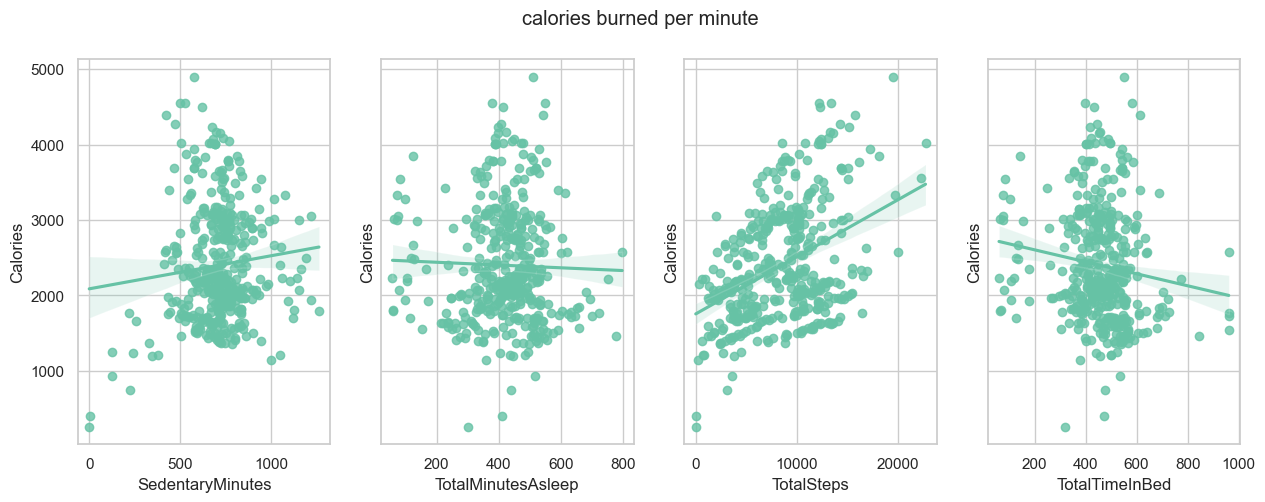

In [ ]:
#a) Initial Exploratory Visualizations
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
fig.suptitle('calories burned per minute')

sns.regplot(data = fitbit_df, x = 'SedentaryMinutes', y = 'Calories', ax=axes[0])

sns.regplot(data = fitbit_df, x = 'TotalMinutesAsleep', y = 'Calories', ax=axes[1])

sns.regplot(data = fitbit_df, x = 'TotalSteps', y = 'Calories', ax=axes[2])

sns.regplot(data = fitbit_df, x = 'TotalTimeInBed', y = 'Calories', ax=axes[3])

Index(['SedentaryMinutes', 'TotalSteps', 'TotalMinutesAsleep',
       'TotalTimeInBed', 'Calories'],
      dtype='object')


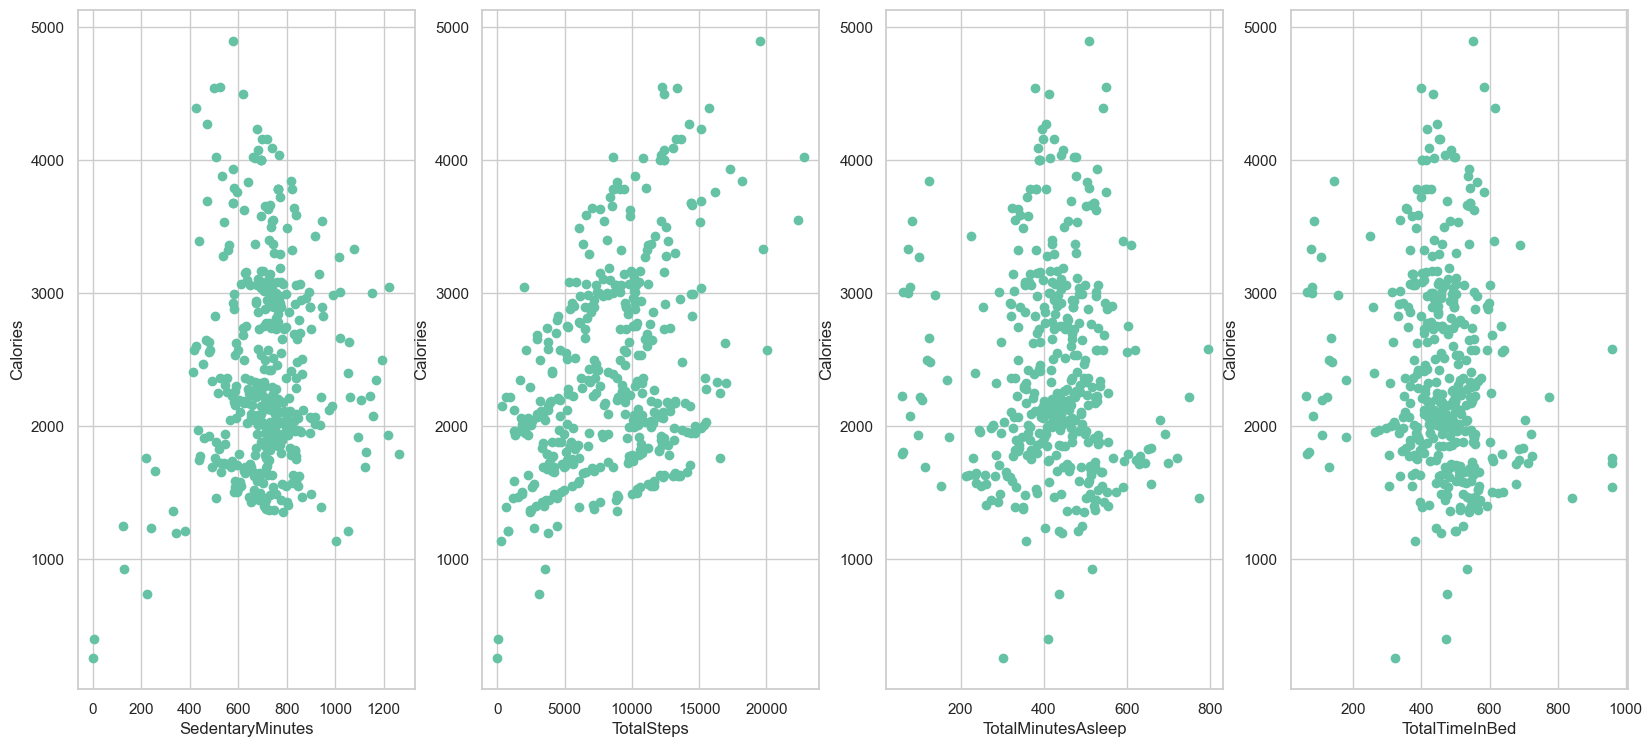

In [ ]:
#correlation measures
column_to_move = fitbit_df.pop("Calories")
fitbit_df.insert(4, "Calories", column_to_move)
print(fitbit_df.columns)

# Define a function to plot the scatterplots of the relationships between
# all independent variables and the dependent variable
def plot_relationships(df, num_cols):
    variables = df.columns

    # assume that the dependent variable is in the last column
    dep_var = variables[-1]
    ind_var = variables[:-1]
    figs = len(dep_var)
    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    fig = 1
    plt.figure(figsize=(20,30))
    # Loop through all independent variables and create the scatter plot
    for i in ind_var:
        pltfignums = [str(num_rows), str(num_cols), str(fig)]
        pltfig = int(''.join(pltfignums))
        plt.subplot(pltfig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1

plot_relationships(fitbit_df,4)

<Axes: >

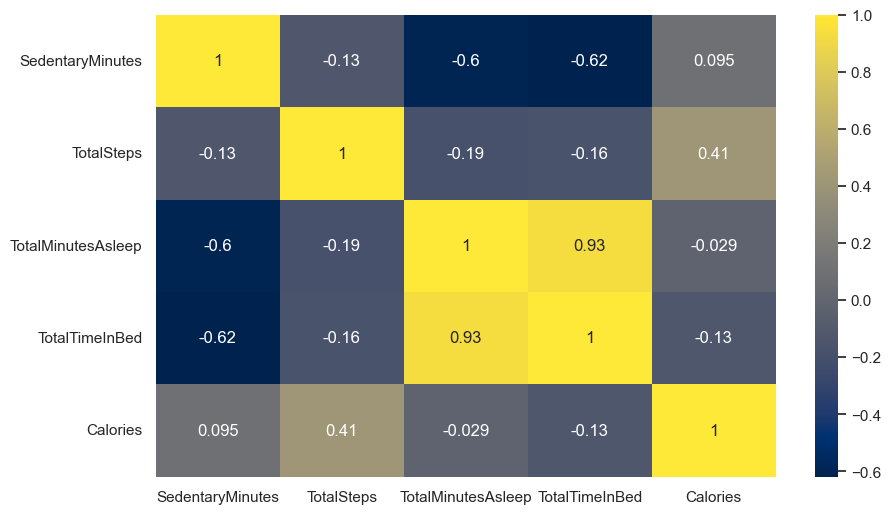

In [ ]:
# Plot the correlations as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(fitbit_df.corr(), annot=True, cmap='cividis', fmt='.2g')

In [ ]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(fitbit_df.iloc[:,:-1],
                                                              fitbit_df['Calories'],
                                                              test_size=0.2,
                                                              random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, y_train_temp,
                                                      test_size=0.25, random_state=42)

In [ ]:
# scale the data with object range of 0-1
scaler = MinMaxScaler()

scaler.fit_transform(X_train)

scaler.transform(X_valid)
scaler.transform(X_test)

array([[0.63330599, 0.36764383, 0.40785908, 0.37555556],
       [0.59557014, 0.45576408, 0.57859079, 0.48777778],
       [0.6997539 , 0.0528282 , 0.5799458 , 0.49111111],
       [0.56193601, 0.54379642, 0.44715447, 0.38444444],
       [0.90730107, 0.20476421, 0.06504065, 0.05222222],
       [0.61443806, 0.31455193, 0.38617886, 0.33222222],
       [0.39294504, 0.42082363, 0.73441734, 0.63888889],
       [0.59639048, 0.49997802, 0.49186992, 0.44      ],
       [0.54060705, 0.47061926, 0.49728997, 0.41555556],
       [0.6923708 , 0.60326111, 0.09214092, 0.08444444],
       [0.3388023 , 0.35990858, 0.57181572, 0.53888889],
       [0.5561936 , 0.36171054, 0.59891599, 0.55111111],
       [0.62674323, 0.23829825, 0.47425474, 0.43222222],
       [0.58736669, 0.30769569, 0.61382114, 0.53555556],
       [0.47087777, 0.40047466, 0.63821138, 0.55222222],
       [0.73420837, 0.08996616, 0.44715447, 0.40333333],
       [0.43478261, 0.28774228, 0.6504065 , 0.55444444],
       [0.47497949, 0.8581286 ,

In [ ]:
def scoring(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mae = mean_absolute_error(test_labels, predictions)
    mse = mean_squared_error(test_labels, predictions)
    r2 = r2_score(test_labels, predictions)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Mean Absolute Error: {:0.4f}.'.format(mae))
    print('Mean Squared Error: {:0.4f}.'.format(mse))
    print('R^2 Score = {:0.4f}.'.format(r2))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

# Create list of median predictions that has the same length as y_valid
baseline_y = [y_train.median()] * len(y_valid)

# Compute the relevant scores
base_predictions = baseline_y
base_mae = mean_absolute_error(y_valid, base_predictions)
base_mse = mean_squared_error(y_valid, base_predictions)
base_r2 = r2_score(y_valid, base_predictions)
base_errors = abs(base_predictions - y_valid)
base_mape = 100 * np.mean(base_errors / y_valid)
base_accuracy = 100 - base_mape
print('Model Performance')
print('Mean Absolute Error: {:0.4f}.'.format(base_mae))
print('Mean Squared Error: {:0.4f}.'.format(base_mse))
print('R^2 Score = {:0.4f}.'.format(base_r2))
print('Accuracy = {:0.2f}%.'.format(base_accuracy))

Model Performance
Mean Absolute Error: 649.0120.
Mean Squared Error: 650005.8072.
R^2 Score = -0.0292.
Accuracy = 72.74%.


In [ ]:
#We want to establish baseline scores based on the performance of a model which predicts the mean everytime. The baseline is useful to assess whether the models we are going to train are actually 'learning' anything from the data

Text(0, 0.5, 'Coefficients')

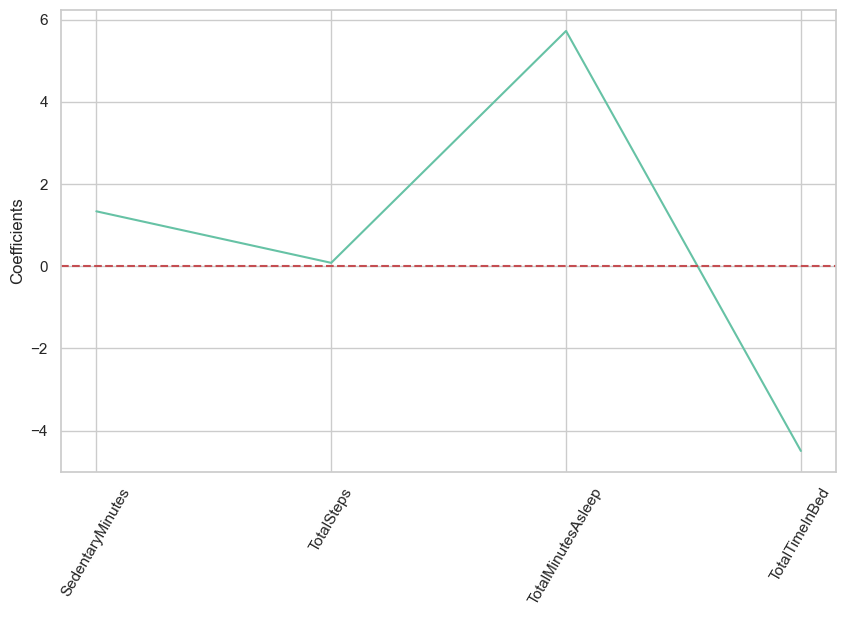

In [ ]:
# feature selection with lasso Regression
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_

plt.figure(figsize=(10, 6))
plt.plot(range(len(X_train.columns)), lasso_coef)
plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=60)
plt.axhline(0.0, linestyle='--', color='r')
plt.ylabel('Coefficients')

In [ ]:
#b) tree machine learning models RandomForest classifier
rf_regressor = rf_sk(random_state=42)
rf = rf_regressor.fit(X_train, y_train)

scoring(rf, X_valid, y_valid)

Model Performance
Mean Absolute Error: 506.9816.
Mean Squared Error: 407747.2590.
R^2 Score = 0.3544.
Accuracy = 77.49%.


In [ ]:
# decision tree classifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt_classifier=DecisionTreeClassifier()

In [ ]:
model=dt_classifier.fit(X_train,y_train)

In [ ]:
scoring(model,X_valid,y_valid)

Model Performance
Mean Absolute Error: 675.3494.
Mean Squared Error: 833114.9398.
R^2 Score = -0.3191.
Accuracy = 69.59%.


In [ ]:
#on comparing the two tree models random forest and DecisionTree Classifier the random forest model performs better with 77.49 % accuracy with high R^2 value

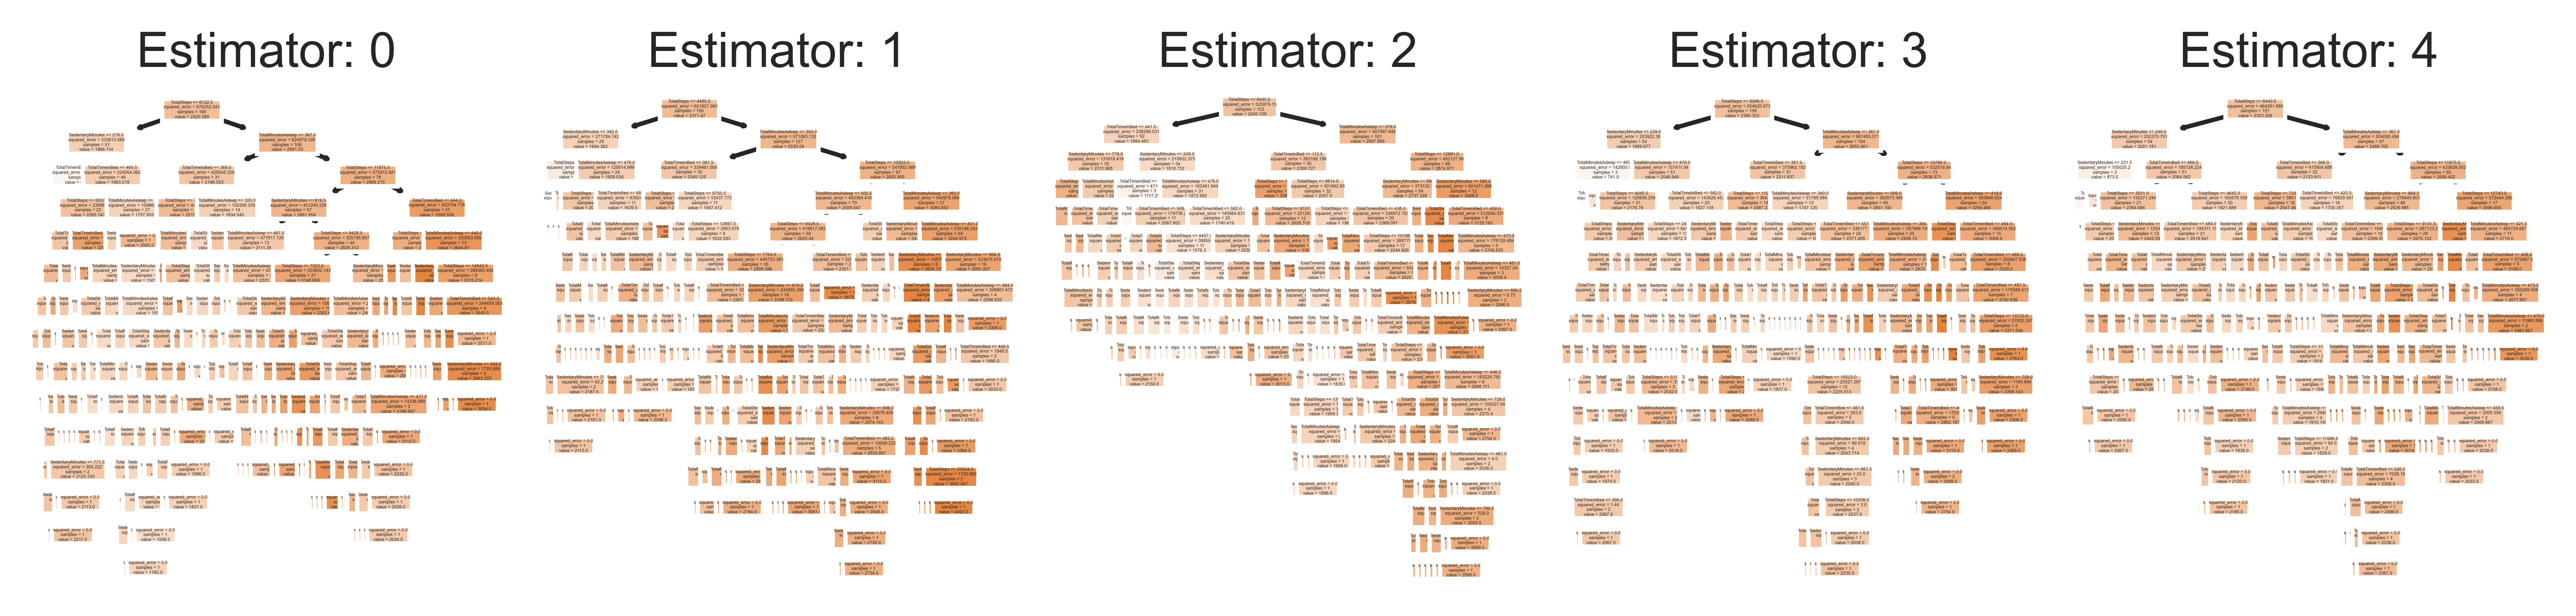

In [ ]:
# let's take a look at the first 5 estimators in the Random Forest
fn=['SedentaryMinutes', 'TotalSteps', 'TotalMinutesAsleep',
       'TotalTimeInBed']
cn=['Calories']
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
    tree.plot_tree(rf.estimators_[index],
                   feature_names = fn,
                   class_names=cn,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)

In [ ]:
#c)Choose the best performing model from Q.2b to implement a scalable workflow
using PySpark and report your observations.
fitbit_df.to_csv('fitbit_df.csv', index=False)

CSV_PATH = "./fitbit_df.csv"
APP_NAME = "Random Forest"
SPARK_URL = "local[*]"
RANDOM_SEED = 13579
TRAINING_DATA_RATIO = 0.7
RF_NUM_TREES = 3
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

spark = SparkSession.builder \
    .appName(APP_NAME) \
    .master(SPARK_URL) \
    .getOrCreate()

df = spark.read \
    .options(header = "true", inferschema = "true") \
    .csv(CSV_PATH)

print("Total number of rows: %d" % df.count())

df.printSchema()

df.show()

Total number of rows: 413
root
 |-- SedentaryMinutes: integer (nullable = true)
 |-- TotalSteps: integer (nullable = true)
 |-- TotalMinutesAsleep: integer (nullable = true)
 |-- TotalTimeInBed: integer (nullable = true)
 |-- Calories: integer (nullable = true)

+----------------+----------+------------------+--------------+--------+
|SedentaryMinutes|TotalSteps|TotalMinutesAsleep|TotalTimeInBed|Calories|
+----------------+----------+------------------+--------------+--------+
|             728|     13162|               327|           346|    1985|
|             776|     10735|               384|           407|    1797|
|             726|      9762|               412|           442|    1745|
|             773|     12669|               340|           367|    1863|
|             539|      9705|               700|           712|    1728|
|             775|     15506|               304|           320|    2035|
|             818|     10544|               360|           377|    1786|
|      

In [ ]:
# create features
featureCols = ['SedentaryMinutes', 'TotalSteps', 'TotalMinutesAsleep',
       'TotalTimeInBed']
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
df = assembler.transform(df)
spark_df = df.select(['features', 'Calories'])

spark_df.show()
spark_df.printSchema()

+--------------------+--------+
|            features|Calories|
+--------------------+--------+
|[728.0,13162.0,32...|    1985|
|[776.0,10735.0,38...|    1797|
|[726.0,9762.0,412...|    1745|
|[773.0,12669.0,34...|    1863|
|[539.0,9705.0,700...|    1728|
|[775.0,15506.0,30...|    2035|
|[818.0,10544.0,36...|    1786|
|[838.0,9819.0,325...|    1775|
|[732.0,14371.0,36...|    1949|
|[709.0,10039.0,43...|    1788|
|[814.0,15355.0,27...|    2013|
|[833.0,13755.0,24...|    1970|
|[782.0,13154.0,36...|    1898|
|[815.0,11181.0,34...|    1837|
|[712.0,14673.0,40...|    1947|
|[730.0,10602.0,36...|    1820|
|[798.0,14727.0,27...|    2004|
|[816.0,15103.0,27...|    1990|
|[857.0,14070.0,24...|    1959|
|[754.0,12159.0,33...|    1896|
+--------------------+--------+
only showing top 20 rows

root
 |-- features: vector (nullable = true)
 |-- Calories: integer (nullable = true)



In [ ]:
train, test = spark_df.randomSplit([0.8, 0.2], seed = 42)
print("Number of training set rows: %d" % train.count())
print("Number of test set rows: %d" % test.count())

Number of training set rows: 354
Number of test set rows: 59


In [ ]:
rf = rf_sp(featuresCol="features", labelCol='Calories')

model = rf.fit(train)

predictions = model.transform(test)

predictions.select("prediction", "Calories", "features").show(5)

preds = predictions.select('prediction').toPandas()['prediction']
test_labels = predictions.select('Calories').toPandas()['Calories']

errors = abs(preds - test_labels)
mape = 100 * np.mean(errors / test_labels)
accuracy = round(100 - mape, 4)
print(f'Accuracy = {accuracy} %')

+------------------+--------+--------------------+
|        prediction|Calories|            features|
+------------------+--------+--------------------+
|           1733.35|    1248|[125.0,4477.0,492...|
|1087.5881990231992|    1240|[241.0,2752.0,404...|
|2482.0934914487307|    1364|[330.0,8891.0,456...|
| 2467.814564470267|    2606|[425.0,11135.0,46...|
| 2465.741686834783|    2469|[456.0,7336.0,498...|
+------------------+--------+--------------------+
only showing top 5 rows

Accuracy = 76.2172 %


In [ ]:
#by using the pyspark for random forest we get accuracy of 76.2172%

In [ ]:
#d)Predict the calories using linear machine learning models and report the results.
regressor = LinearRegression()
mlr = regressor.fit(X_train, y_train)

scoring(mlr, X_valid, y_valid)

Model Performance
Mean Absolute Error: 571.5923.
Mean Squared Error: 461353.1211.
R^2 Score = 0.2695.
Accuracy = 74.79%.


3)
A data scientist has to build an Artificial Neural Network (ANN) model consisting of
two hidden layers with activation function Rectifier Unit and sigmoid function at the
output layer for the dataset shown in Table.2. Design an ensemble workflow and Code
the steps involved in building an ANN using tensorflow with batch size 34 and 100
epochs. Also, predict if the customer with information shown in Table.2 will churn the
telecom service:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt


In [ ]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%cd D:\predictive_data_analysis\data

D:\predictive_data_analysis\data


In [ ]:
df=pd.read_csv("Telecom Customer Management.csv")

In [ ]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [ ]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le=LabelEncoder()
df["gender"]=le.fit_transform(df["gender"])
df["Partner"]=le.fit_transform(df["Partner"])
df["Dependents"]=le.fit_transform(df["Dependents"])
df["PhoneService"]=le.fit_transform(df["PhoneService"])
df["MultipleLines"]=le.fit_transform(df["MultipleLines"])
df["InternetService"]=le.fit_transform(df["InternetService"])
df["OnlineSecurity"]=le.fit_transform(df["OnlineSecurity"])
df["OnlineBackup"]=le.fit_transform(df["OnlineBackup"])
df["DeviceProtection"]=le.fit_transform(df["DeviceProtection"])
df["TechSupport"]=le.fit_transform(df["TechSupport"])
df["StreamingTV"]=le.fit_transform(df["StreamingTV"])
df["StreamingMovies"]=le.fit_transform(df["StreamingMovies"])
df["Contract"]=le.fit_transform(df["Contract"])
df["PaperlessBilling"]=le.fit_transform(df["PaperlessBilling"])
df["PaymentMethod"]=le.fit_transform(df["PaymentMethod"])
df["TotalCharges"]=le.fit_transform(df["TotalCharges"])
df["Churn"]=le.fit_transform(df["Churn"])

In [ ]:
x=df.iloc[:,2:-1].values
y=df.iloc[:,-1].values

In [ ]:
x

array([[0.0000e+00, 1.0000e+00, 0.0000e+00, ..., 2.0000e+00, 2.9850e+01,
        2.5050e+03],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 3.0000e+00, 5.6950e+01,
        1.4660e+03],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 3.0000e+00, 5.3850e+01,
        1.5700e+02],
       ...,
       [0.0000e+00, 1.0000e+00, 1.0000e+00, ..., 2.0000e+00, 2.9600e+01,
        2.9940e+03],
       [1.0000e+00, 1.0000e+00, 0.0000e+00, ..., 3.0000e+00, 7.4400e+01,
        2.6600e+03],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 1.0565e+02,
        5.4070e+03]])

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct=ColumnTransformer(transformers=[("encoder",OneHotEncoder(),[1])],remainder="passthrough")
x=np.array(ct.fit_transform(x))
print(x)

[[0.0000e+00 1.0000e+00 0.0000e+00 ... 2.0000e+00 2.9850e+01 2.5050e+03]
 [1.0000e+00 0.0000e+00 0.0000e+00 ... 3.0000e+00 5.6950e+01 1.4660e+03]
 [1.0000e+00 0.0000e+00 0.0000e+00 ... 3.0000e+00 5.3850e+01 1.5700e+02]
 ...
 [0.0000e+00 1.0000e+00 0.0000e+00 ... 2.0000e+00 2.9600e+01 2.9940e+03]
 [0.0000e+00 1.0000e+00 1.0000e+00 ... 3.0000e+00 7.4400e+01 2.6600e+03]
 [1.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 1.0565e+02 5.4070e+03]]


In [ ]:
#split the data into train and test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [ ]:
#feature scaling
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.fit_transform(x_test)

In [ ]:
x_train.shape

(5634, 19)

In [ ]:
#initialize the ANN
ann=tf.keras.models.Sequential()
#adding the input layer and first hidden layer
ann.add(tf.keras.layers.Dense(units=6,input_shape=(19,),activation="relu"))
#adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=6,activation="relu"))
#adding the output layer
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

In [ ]:
#compiling the ANN
ann.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
#training the ANN on the training set
ann.fit(x_train,y_train,batch_size=34,epochs=100)

Epoch 1/100
166/166 [==============================] - 2s 3ms/step - loss: 0.5820 - accuracy: 0.7217
Epoch 2/100
166/166 [==============================] - 0s 3ms/step - loss: 0.4925 - accuracy: 0.7362
Epoch 3/100
166/166 [==============================] - 0s 3ms/step - loss: 0.4619 - accuracy: 0.7767
Epoch 4/100
166/166 [==============================] - 0s 3ms/step - loss: 0.4464 - accuracy: 0.7767
Epoch 5/100
166/166 [==============================] - 0s 3ms/step - loss: 0.4371 - accuracy: 0.7849
Epoch 6/100
166/166 [==============================] - 0s 3ms/step - loss: 0.4312 - accuracy: 0.7886
Epoch 7/100
166/166 [==============================] - 0s 3ms/step - loss: 0.4277 - accuracy: 0.7890
Epoch 8/100
166/166 [==============================] - 1s 3ms/step - loss: 0.4248 - accuracy: 0.7927
Epoch 9/100
166/166 [==============================] - 1s 4ms/step - loss: 0.4223 - accuracy: 0.7939
Epoch 10/100
166/166 [==============================] - 0s 3ms/step - loss: 0.4210 - accura

In [ ]:
df["gender"].nunique()
df["Partner"].nunique()
df["Dependents"].nunique()
df["PhoneService"].nunique()
df["MultipleLines"].nunique()
df["InternetService"].nunique()
df["OnlineSecurity"].nunique()
df["OnlineBackup"].nunique()
df["DeviceProtection"].nunique()
df["TechSupport"].nunique()
df["StreamingTV"].nunique()
df["StreamingMovies"].nunique()
df["Contract"].nunique()
df["PaperlessBilling"].nunique()
df["PaymentMethod"].nunique()
df["TotalCharges"].nunique()

6531

In [ ]:
df.head()

customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0  7590-VHVEG       0              0        1           0       1   
1  5575-GNVDE       1              0        0           0      34   
2  3668-QPYBK       1              0        0           0       2   
3  7795-CFOCW       1              0        0           0      45   
4  9237-HQITU       0              0        0           0       2   

   PhoneService  MultipleLines  InternetService  OnlineSecurity  ...  \
0             0              1                0               0  ...   
1             1              0                0               2  ...   
2             1              0                0               2  ...   
3             0              1                0               2  ...   
4             1              0                1               0  ...   

   TechSupport  StreamingTV  StreamingMovies  Contract  PaperlessBilling  \
0            0            0                0         0                 1   
1            0            0                0         1                 0   
2            0            0                0         0                 1   
3            2            0                0         1                 0   
4            0            0                0         0                 1   

   PaymentMethod  MonthlyCharges  TotalCharges  Churn  encoded_gender  
0              2           29.85          2505      0               0  
1              3           56.95          1466      0               1  
2              3           53.85           157      1               1  
3              0           42.30          1400      0               1  
4              2           70.70           925      1               0  

[5 rows x 22 columns]

In [ ]:
df["gender"].unique()

array([0, 1], dtype=int64)

In [ ]:
df["MultipleLines"].unique()

array([1, 0, 2], dtype=int64)

In [ ]:
print(ann.predict(sc.transform([[1,1,0,1,0,2,0,0,1,0,0,1,0,0,0,1,2,59.85,39.85]]))>0.5)#standard scaler #0.5 is the threshold value for sigmoid function

1/1 [==============================] - 0s 188ms/step
[[False]]


hence the predicted value for given input is false that means the customer will not churn

In [ ]:
#prediction and evaluation
y_pred=ann.predict(x_test)
y_pred=(y_pred>0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.reshape(len(y_test),1)),1))

45/45 [==============================] - 0s 2ms/step
[[0 0]
 [0 0]
 [0 0]
 ...
 [0 1]
 [0 0]
 [1 0]]


In [ ]:
#making the confusion matrix
from sklearn.metrics import confusion_matrix,accuracy_score
cm=confusion_matrix(y_test,y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[929 112]
 [191 177]]


0.7849538679914834

# *11111111111111111111111111111111111111111111111111111111111111111111111*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
%cd D:\predictive_data_analysis

D:\predictive_data_analysis


1. Consider the data from the Federal Reserve Economic Database (FRED) which is
accessible using the link, https://fred.stlouisfed.org/series/IPG2211A2N concerning the
Industrial Production Index for Electricity and Gas Utilities from January 2000 to Jan
2023. Perform the following tasks.
a. Resample the series and choose an essential graph to visualise the month wise
five number summary.
b. Enumerate the components of a time series. Also, isolate the components of the
data series considering the additive and multiplicative models.
[5] CO1 [K3]
2. Is the dataset used in Q.1 is stationary? If yes, justify. Otherwise, make the time series
stationary. Also, using illustrative plots comment on why ARIMA model requires a
time series to be stationary for forecasting.
[5] CO1 [K3]
PAGE 2 OF 2
3. The management of an organisation would like to know the worldwide online visitors
browsing the pages and search engines of their website. The log entries of the users are
stored in a .csv file 'Log_Reg_dataset.csv'. The dataset has various features like
Country, Age, Repeat_Visitor, Search Engine, Web pages Viewed, and Status. Perform
descriptive statistics of each feature using PySpark. Assign probability value 0 and 1
for class 0 and class 1 respectively. Import the required machine learning packages in
PySpark and fit a logistic regression model to predict the Status of the test dataset.
Compute the confusion matrix and report your observation on the classification
metrics.
[10] CO2 [K3]
4. Given the dataset “Superstore.xlsx”, forecast the sales of the category “Office
Supplies” by performing the tasks given below.
a. Explore the dataset to report Stationarity using Rolling plots and Statistical
Tests.
b. Determine the order of differencing, d.
c. Determine the order p for autoregressive process Αℛ(𝑝).
d. Determine the order q for moving averages 𝑀𝐴(𝑞).
e. Fit ARIMA (p, d, q) using Q.4.b, 4.c, and 4.d and report the results with
accuracy metrics.

In [ ]:
%ls

 Volume in drive D is New Volume
 Volume Serial Number is 56AD-6E33

 Directory of D:\predictive_data_analysis

06/07/2023  11:26 AM    <DIR>          .
06/07/2023  11:26 AM    <DIR>          ..
05/08/2023  03:39 PM            12,544 01-NumPy-Indexing-and-Selection.ipynb
05/08/2023  03:39 PM            11,622 02-NumPy-Operations.ipynb
05/09/2023  11:05 AM             4,440 09 May 2023- Load Data.ipynb
05/15/2023  03:28 PM             3,847 15 May 2023 Pandas-Exercises.ipynb
05/15/2023  03:21 PM            11,718 15 May 23 05-Operations.ipynb
05/16/2023  09:30 AM             8,772 15 May 23 DataFrames Practice Exercise .ipynb
05/15/2023  10:54 PM             3,386 15_may_2023.R
05/29/2023  11:32 AM             2,049 airline_passengers.csv
05/23/2023  02:47 PM            10,104 averages.xlsx
05/22/2023  12:58 PM             9,292 CONFUSION_MATRIX.xlsx
06/05/2023  11:20 AM             8,734 cruise_ship_info.csv
06/07/2023  11:18 AM           490,010 CSC620 CA1 Predictive Analytics.pdf
05/

In [ ]:
df=pd.read_csv("fred_elec_gas.csv",index_col=0,parse_dates=True)

In [ ]:
df

IPG2211A2N
DATE                  
1939-01-01      3.3336
1939-02-01      3.3591
1939-03-01      3.4354
1939-04-01      3.4609
1939-05-01      3.4609
...                ...
2022-12-01    119.2465
2023-01-01    116.1139
2023-02-01    106.4287
2023-03-01    107.0790
2023-04-01     91.2385

[1012 rows x 1 columns]

In [ ]:
#a) Resample the data to monthly frequency ('M')
monthly_data = df.resample('M').mean()

# Calculate the five-number summary using describe()
summary = monthly_data.describe().loc[['min', '25%', '50%', '75%', 'max']]

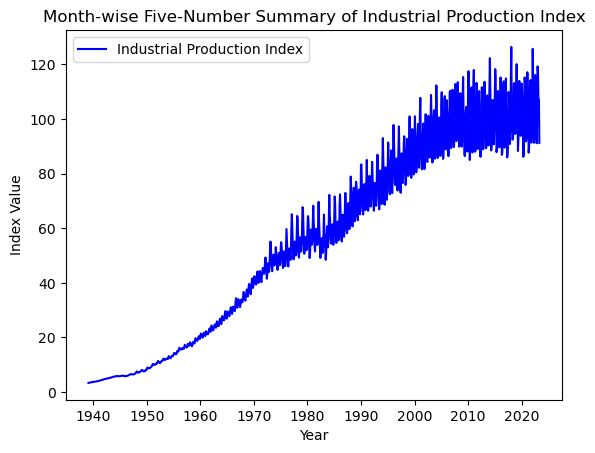

In [ ]:
# Plotting the graph
fig, ax = plt.subplots()
ax.plot(monthly_data.index, monthly_data['IPG2211A2N'], color='blue', label='Industrial Production Index')
ax.set_xlabel('Year')
ax.set_ylabel('Index Value')
ax.set_title('Month-wise Five-Number Summary of Industrial Production Index')
ax.legend()

In [ ]:
#calculate five summary of month wise
summary

IPG2211A2N
min    3.333600
25%   20.485150
50%   56.325000
75%   88.892175
max  126.373300

In [ ]:
import seaborn as sns

In [ ]:
df["Month"]=pd.DatetimeIndex(df.index).month

Text(0, 0.5, 'industrial production of electric and gas utilities')

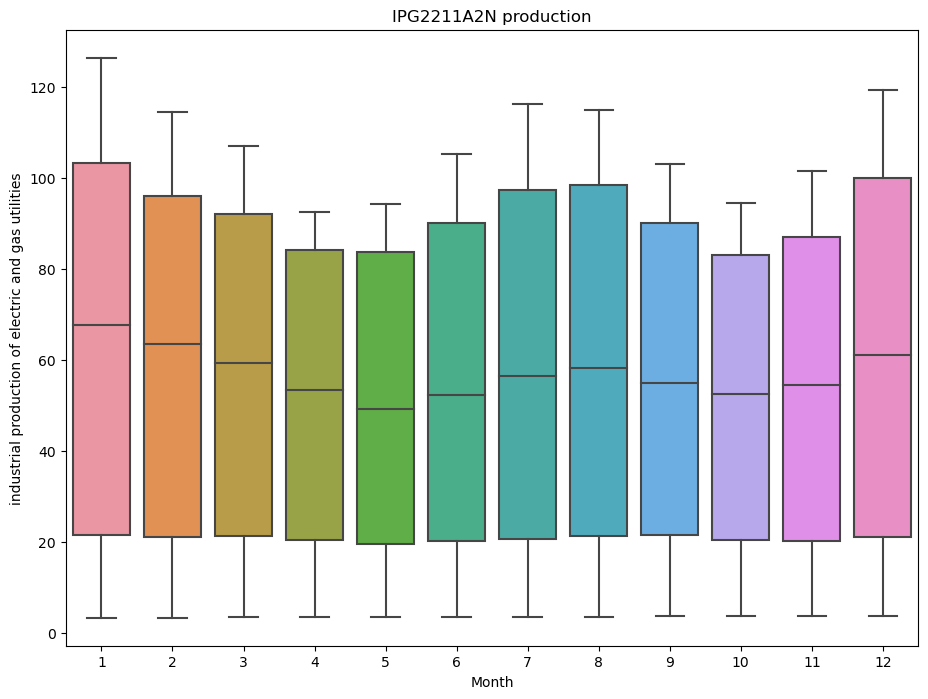

In [ ]:
fig,ax=plt.subplots(figsize=(11,8))
sns.boxplot(data=df,x="Month",y="IPG2211A2N",ax=ax)
ax.set_title("IPG2211A2N production")
ax.set_ylabel("industrial production of electric and gas utilities")

In [ ]:
plt.style.use('fivethirtyeight')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 5

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

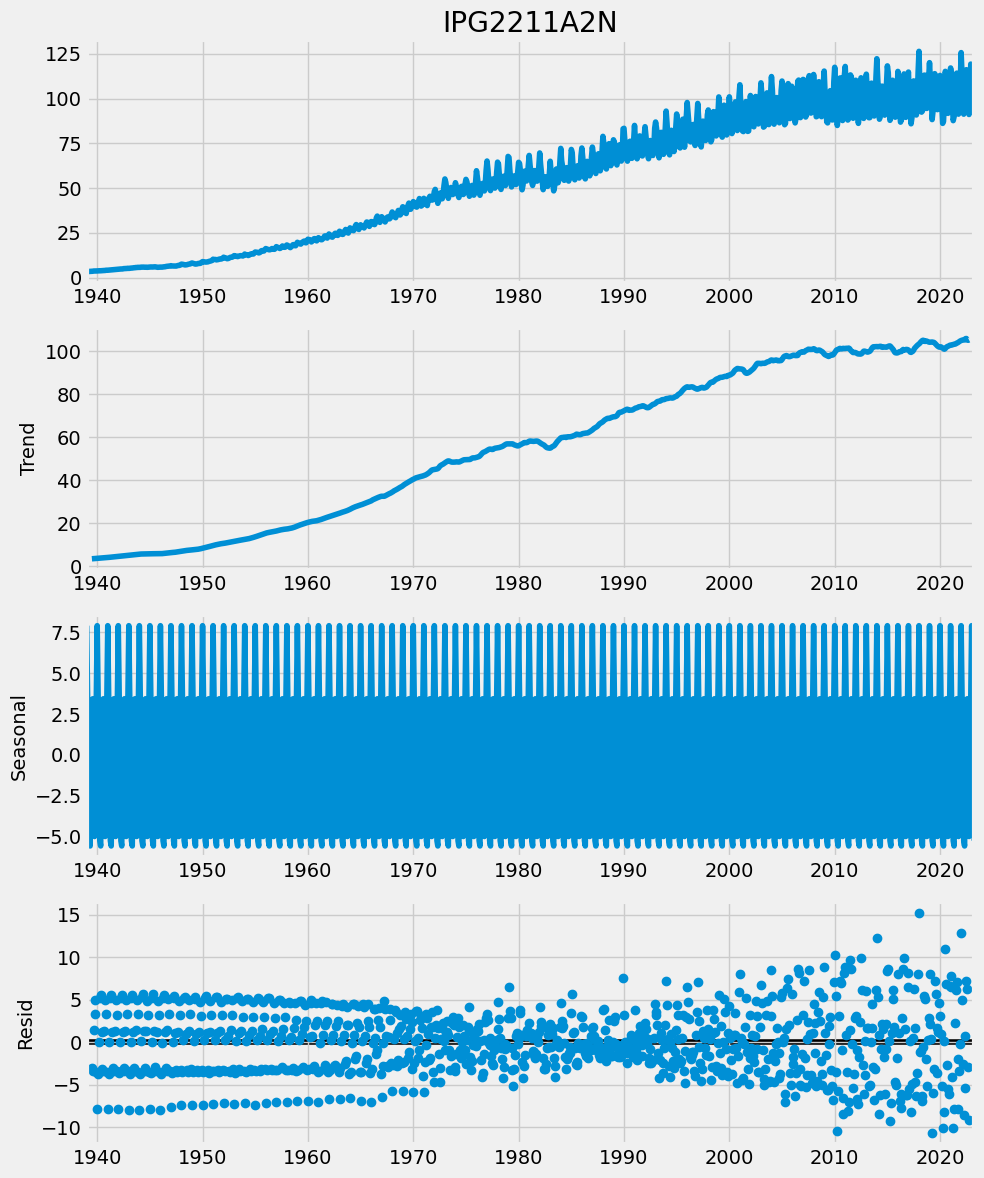

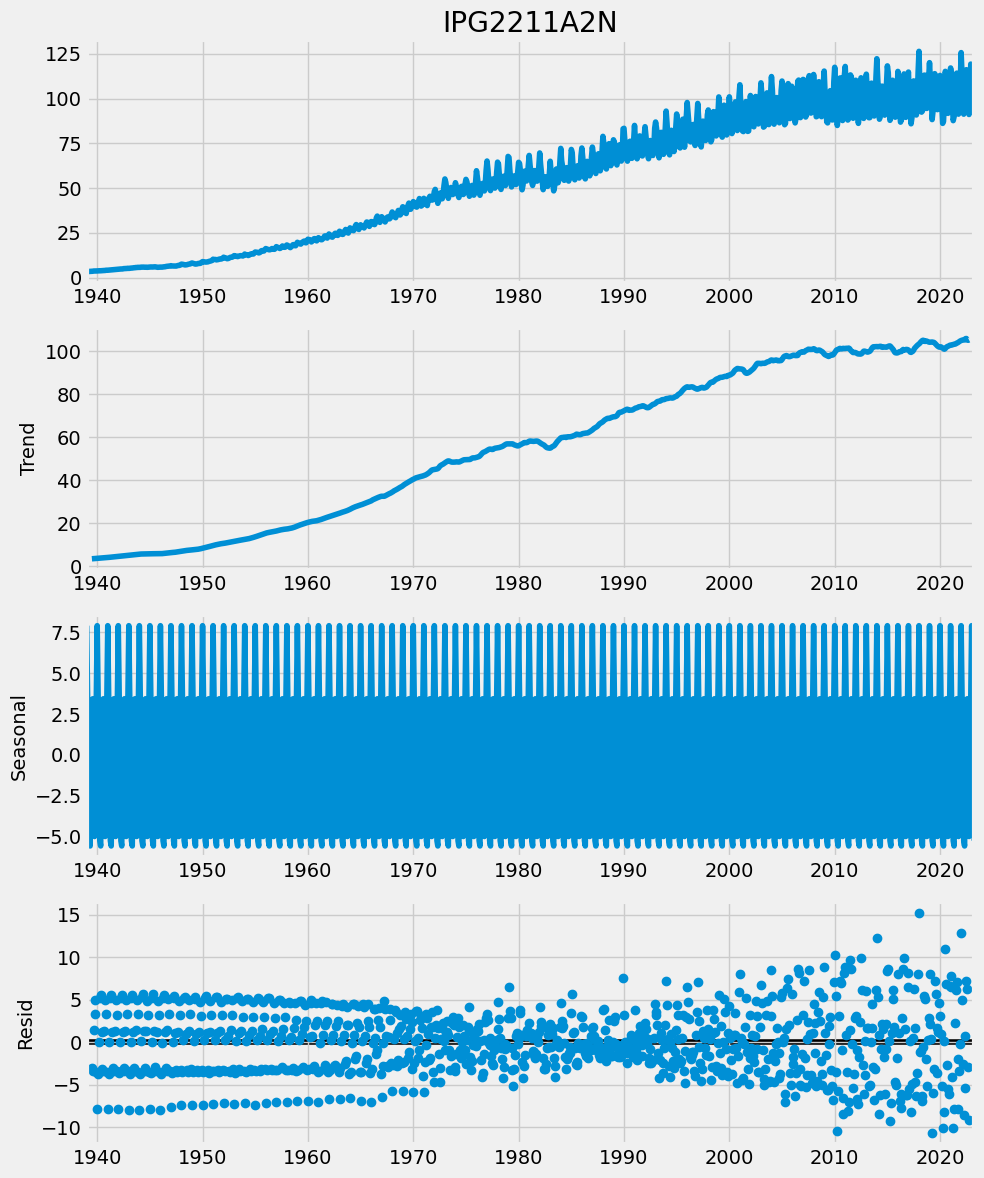

In [ ]:
#b)enumerate the components of time series using additive and multiplicative time series analysis
rcParams["figure.figsize"]=10,12
result_additive=seasonal_decompose(df["IPG2211A2N"],model="additive")
result_additive.plot()

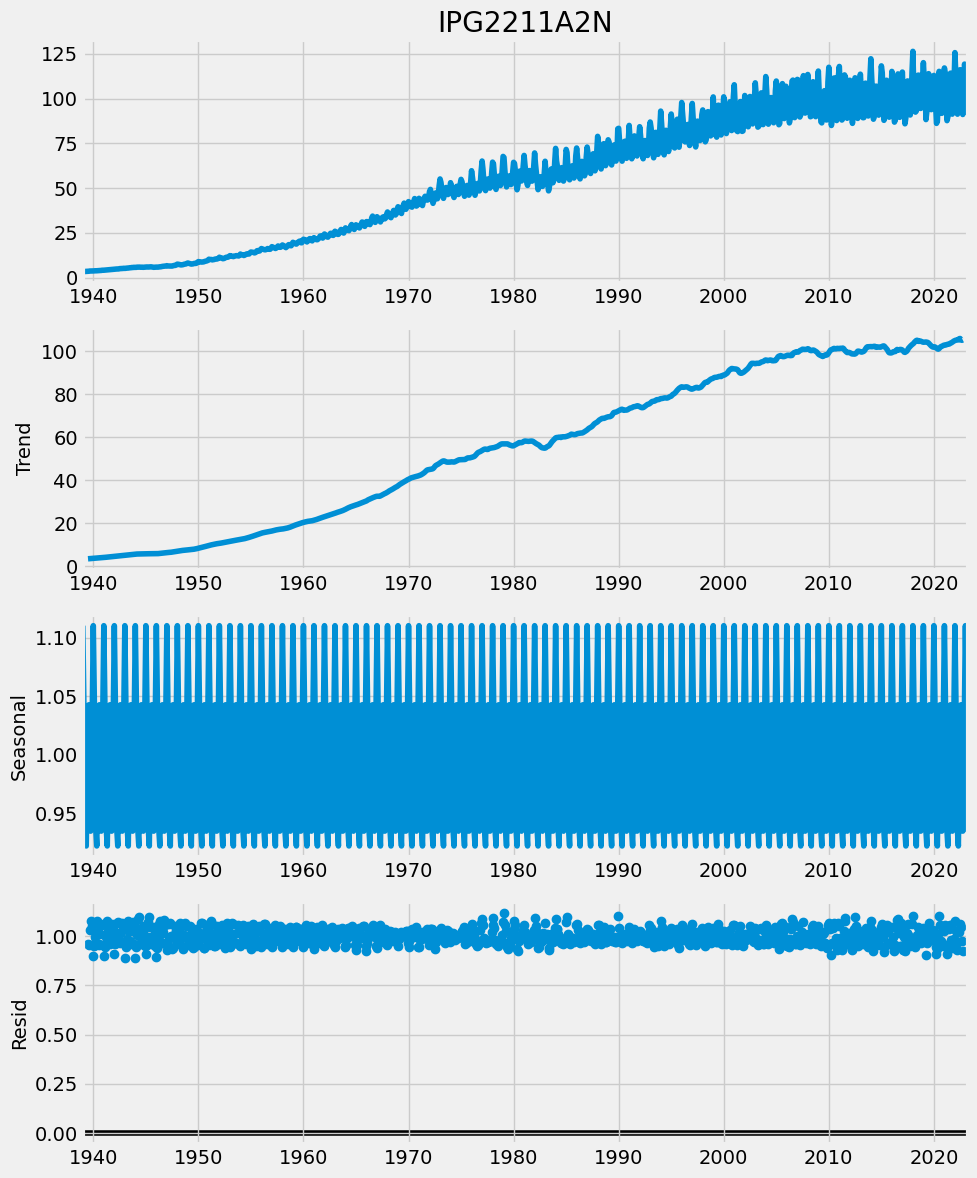

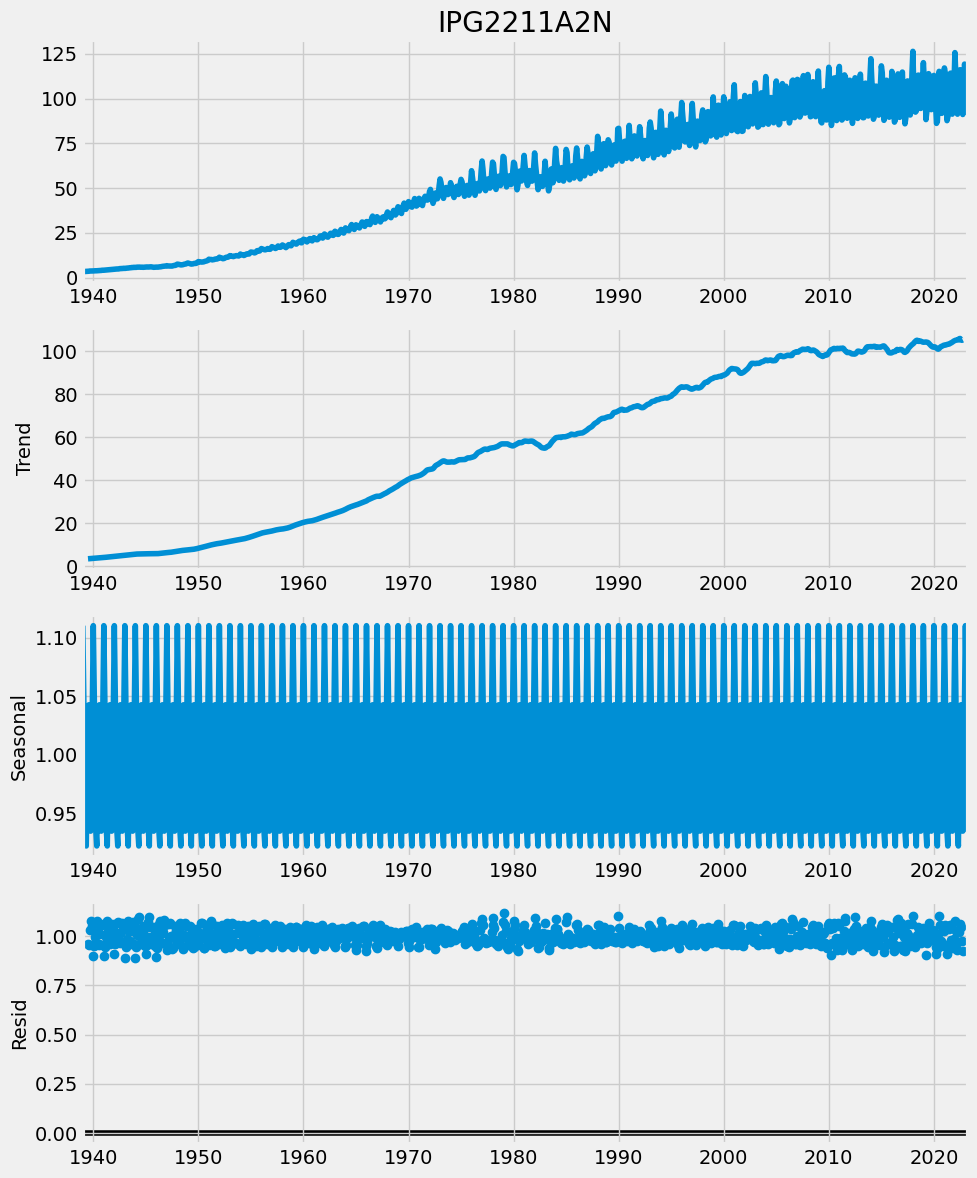

In [ ]:
rcParams["figure.figsize"]=10,12
result_additive=seasonal_decompose(df["IPG2211A2N"],model="multiplicative")
result_additive.plot()

#2. Is the dataset used in Q.1 is stationary? If yes, justify. Otherwise, make the time series
#stationary. Also, using illustrative plots comment on why ARIMA model requires a
#time series to be stationary for forecasting.

Stationary test: Method 3: Augmented Dickey-Fuller test - (ADF) test
H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.

HA: The time series is stationary.

If the p-value from the test is less than some significance level (e.g. α = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [ ]:
df['Year'] = pd.DatetimeIndex(df.index).year
df['Day Name'] = pd.DatetimeIndex(df.index).day_name()

In [ ]:
df["Year"].nunique()

85

In [ ]:
for year in np.unique(df.Year):
    X=df.loc[str(year)]["IPG2211A2N"].values
    result=adfuller(X)
    print("\n for the year:",year)
    print("ADF Statistic: %f"% result[0])
    print("p-value: %f" % result[1])
    for key,value in result[4].items():
        print("\t%5s: %8.3f" %(key,value))
X=df["IPG2211A2N"].values
result=adfuller(X)
print("\n for the consolidated 85 years")
print("ADF statistic %f" % result[0])
print("p-value %f" %result[1])
print("critical values")
for key,value in result[4].items():
    print("\t%5s %8.3f"%(key,value))


 for the year: 1939
ADF Statistic: -7.080053
p-value: 0.000000
	   1%:   -4.939
	   5%:   -3.478
	  10%:   -2.844

 for the year: 1940
ADF Statistic: 2.047043
p-value: 0.998731
	   1%:   -4.939
	   5%:   -3.478
	  10%:   -2.844

 for the year: 1941
ADF Statistic: -0.862783
p-value: 0.799981
	   1%:   -4.939
	   5%:   -3.478
	  10%:   -2.844

 for the year: 1942
ADF Statistic: 0.265914
p-value: 0.975725
	   1%:   -4.223
	   5%:   -3.189
	  10%:   -2.730

 for the year: 1943
ADF Statistic: -1.313091
p-value: 0.623162
	   1%:   -4.473
	   5%:   -3.290
	  10%:   -2.772

 for the year: 1944
ADF Statistic: -2.532705
p-value: 0.107718
	   1%:   -4.665
	   5%:   -3.367
	  10%:   -2.803

 for the year: 1945
ADF Statistic: -3.230912
p-value: 0.018264
	   1%:   -4.332
	   5%:   -3.233
	  10%:   -2.749

 for the year: 1946
ADF Statistic: 0.179188
p-value: 0.971070
	   1%:   -4.223
	   5%:   -3.189
	  10%:   -2.730

 for the year: 1947
ADF Statistic: 0.052011
p-value: 0.962628
	   1%:   -4.939
	  


 for the year: 2014
ADF Statistic: -11.633767
p-value: 0.000000
	   1%:   -4.939
	   5%:   -3.478
	  10%:   -2.844

 for the year: 2015
ADF Statistic: -10.355866
p-value: 0.000000
	   1%:   -4.332
	   5%:   -3.233
	  10%:   -2.749

 for the year: 2016
ADF Statistic: 139.034625
p-value: 1.000000
	   1%:   -4.939
	   5%:   -3.478
	  10%:   -2.844

 for the year: 2017
ADF Statistic: 0.265597
p-value: 0.975710
	   1%:   -4.939
	   5%:   -3.478
	  10%:   -2.844

 for the year: 2018
ADF Statistic: -2.747407
p-value: 0.066188
	   1%:   -4.332
	   5%:   -3.233
	  10%:   -2.749

 for the year: 2019
ADF Statistic: -1.273505
p-value: 0.641205
	   1%:   -4.939
	   5%:   -3.478
	  10%:   -2.844

 for the year: 2020
ADF Statistic: -5.206205
p-value: 0.000009
	   1%:   -4.332
	   5%:   -3.233
	  10%:   -2.749

 for the year: 2021
ADF Statistic: -9.397700
p-value: 0.000000
	   1%:   -4.332
	   5%:   -3.233
	  10%:   -2.749

 for the year: 2022
ADF Statistic: -2.915901
p-value: 0.043530
	   1%:   -4.9

from the consolidated 85 years of data the p-value is more than 0.05 so it is  stationary

In [ ]:
ts=monthly_data["IPG2211A2N"]

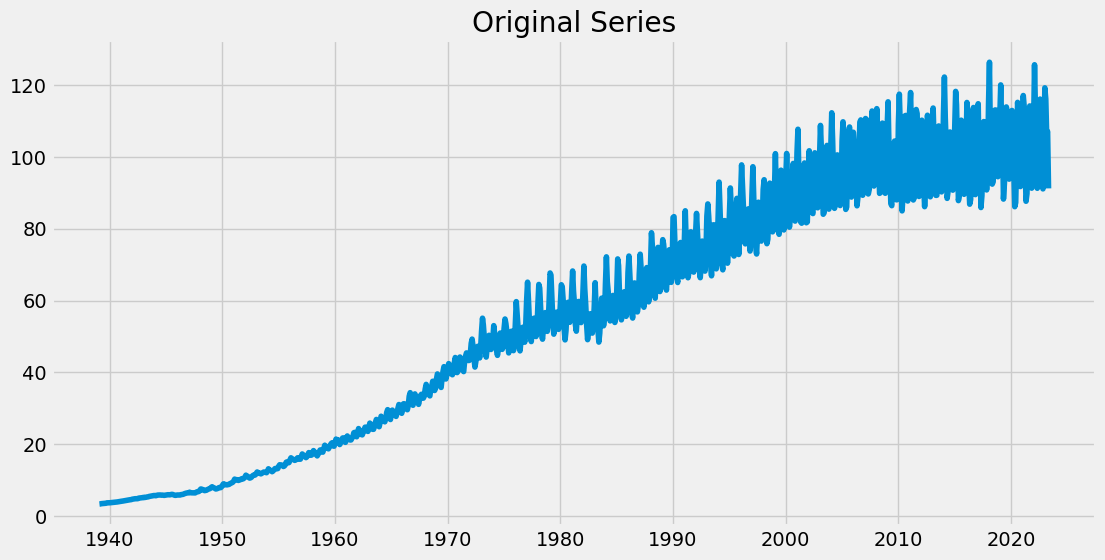

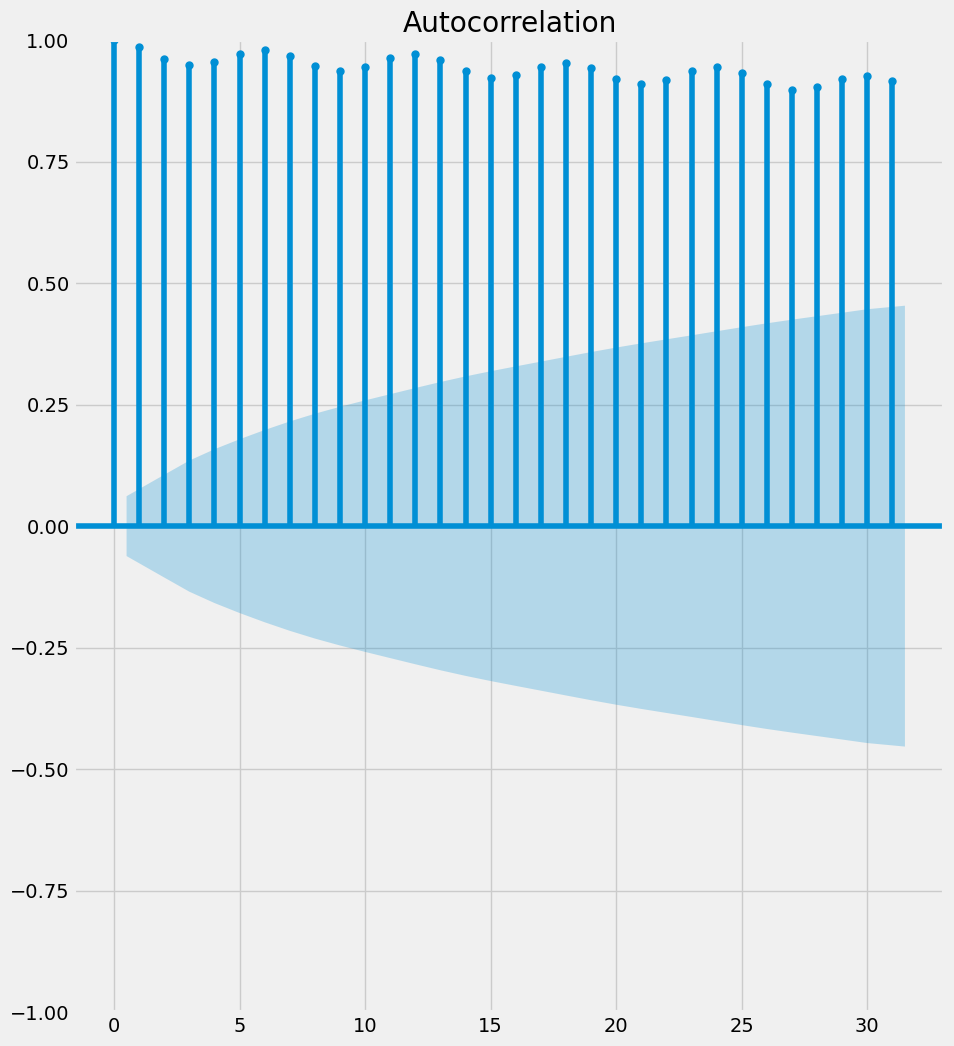

In [ ]:
#Original Series
#fi, axes = plt.subplots(6,1, sharex = True
#fig, axes = plt. subplots(3,2, figsize = (11,8))
plt.figure(figsize=(12,6))

plt.plot(ts)
plt.title('Original Series')
acf0= plot_acf(ts)  #no differencing

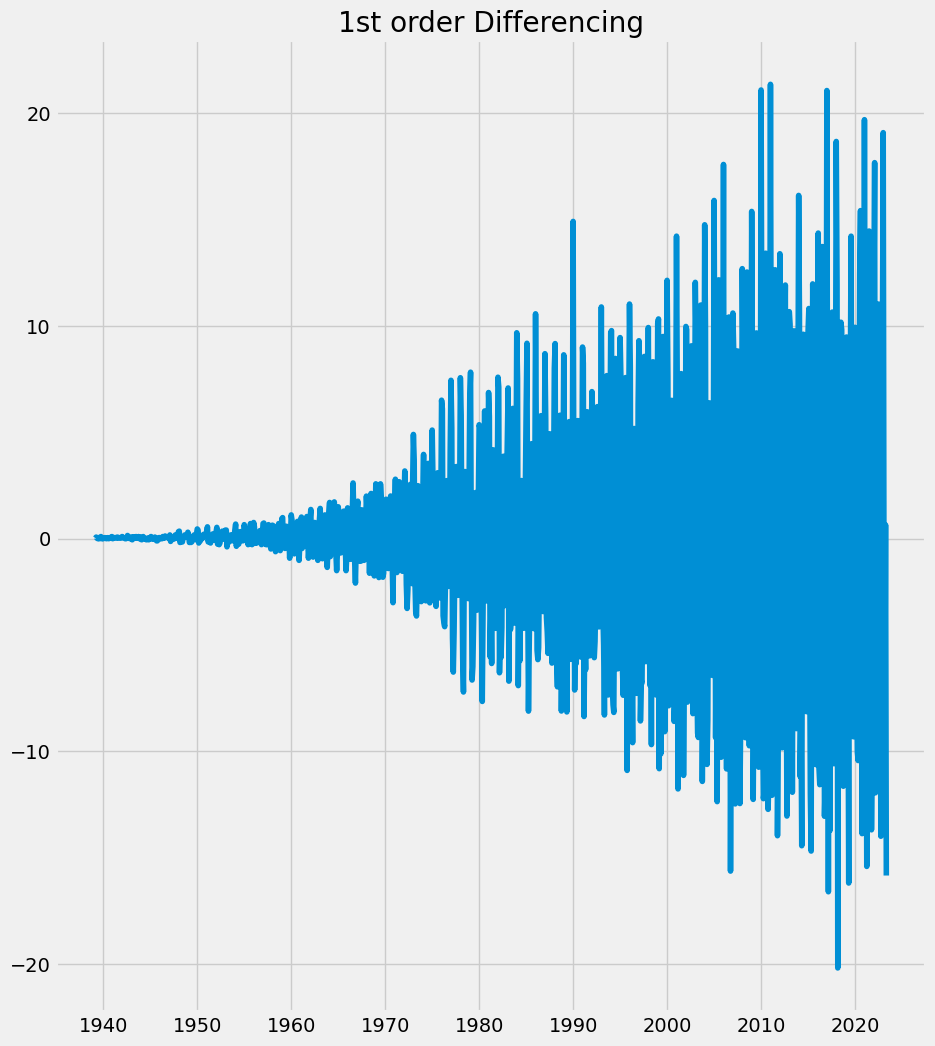

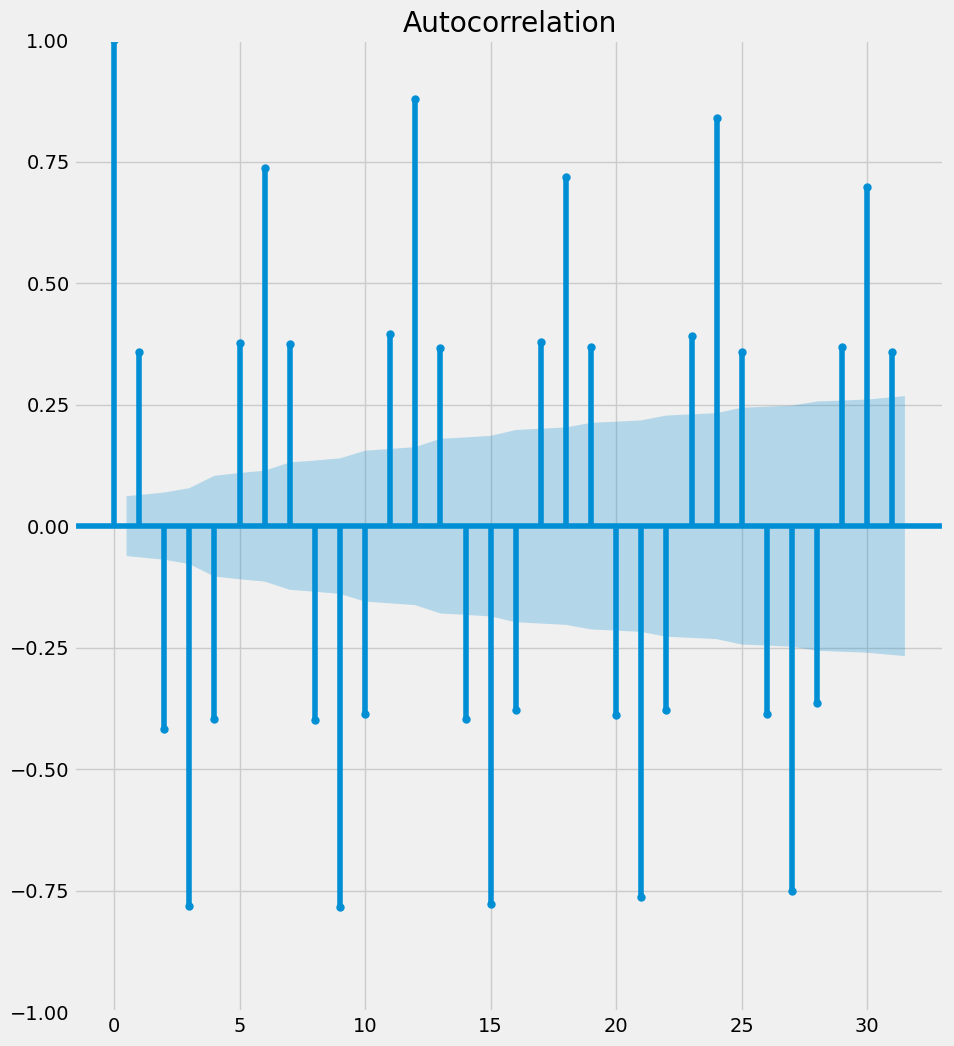

In [ ]:

plt.plot(ts.diff());
plt.title("1st order Differencing")
acf1=plot_acf(ts.diff().dropna())

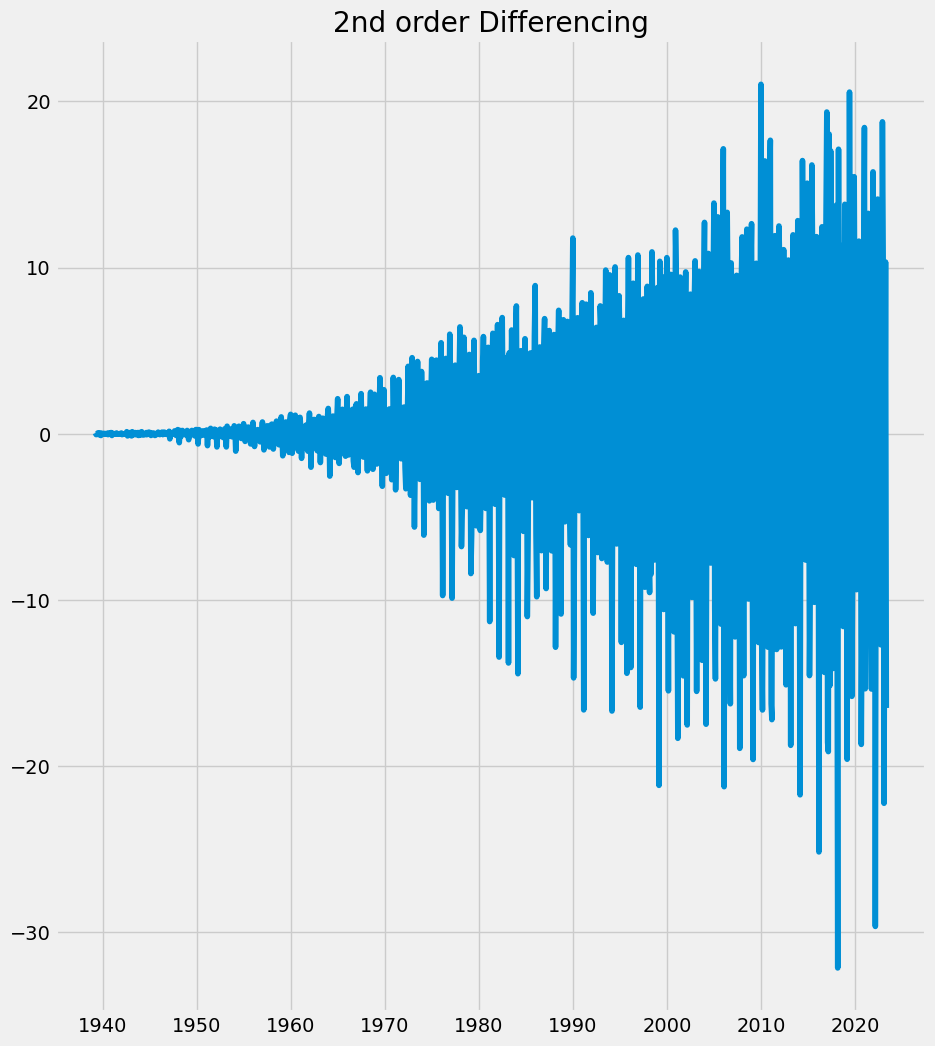

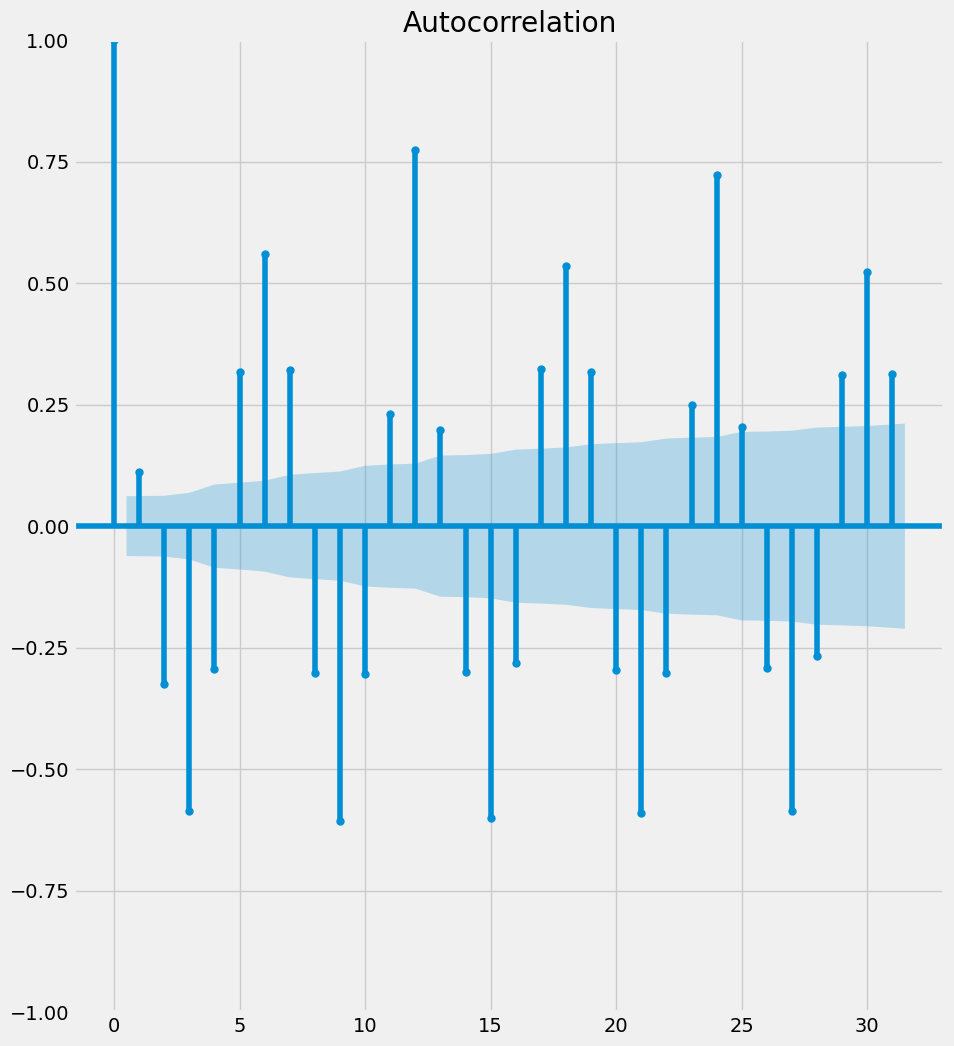

In [ ]:
plt.plot(ts.diff().diff());
plt.title("2nd order Differencing")
acf1=plot_acf(ts.diff().diff().dropna())

 For instance, the widely used ARIMA (Auto-Regressive Integrated Moving Average) model for forecasting makes the assumption that the data is stationary. The model will not be able to faithfully reflect the underlying patterns in the data if it is non-stationary, and the findings will be erroneous.
As an illustration, a non-stationary time series could give the impression that there is a high connection between two variables, but in reality, the correlation is only there because of a trend or a seasonal element in the data.

How to make time series station

#3 )The management of an organisation would like to know the worldwide online visitors
browsing the pages and search engines of their website. The log entries of the users are
stored in a .csv file 'Log_Reg_dataset.csv'. The dataset has various features like
Country, Age, Repeat_Visitor, Search Engine, Web pages Viewed, and Status. Perform
descriptive statistics of each feature using PySpark. Assign probability value 0 and 1
for class 0 and class 1 respectively. Import the required machine learning packages in
PySpark and fit a logistic regression model to predict the Status of the test dataset.
Compute the confusion matrix and report your observation on the classification
metrics.

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyspark

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark=SparkSession.builder.appName("Log_reg").getOrCreate()

In [ ]:
data=spark.read.csv("/content/Log.csv",inferSchema=True,header=True)

In [ ]:
data.show()

+---------+---+-------------+------+------------+-------------+
|  Country|Age|Vist Repeated|Server|viewed PAGES|User Category|
+---------+---+-------------+------+------------+-------------+
|    India| 41|            1| Yahoo|          21|            1|
|   Brazil| 28|            1| Yahoo|           5|            0|
|   Brazil| 40|            0|Google|           3|            0|
|Indonesia| 31|            1|  Bing|          15|            1|
| Malaysia| 32|            0|Google|          15|            1|
|   Brazil| 32|            0|Google|           3|            0|
|   Brazil| 32|            0|Google|           6|            0|
|Indonesia| 27|            0|Google|           9|            0|
|Indonesia| 32|            0| Yahoo|           2|            0|
|Indonesia| 31|            1|  Bing|          16|            1|
| Malaysia| 27|            1|Google|          21|            1|
|Indonesia| 29|            1| Yahoo|           9|            1|
|Indonesia| 33|            1| Yahoo|    

In [ ]:
data.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Vist Repeated: integer (nullable = true)
 |-- Server: string (nullable = true)
 |-- viewed PAGES: integer (nullable = true)
 |-- User Category: integer (nullable = true)



In [ ]:
data.describe().show()

+-------+--------+-----------------+-----------------+------+-----------------+------------------+
|summary| Country|              Age|    Vist Repeated|Server|     viewed PAGES|     User Category|
+-------+--------+-----------------+-----------------+------+-----------------+------------------+
|  count|   20000|            20000|            20000| 20000|            20000|             20000|
|   mean|    null|         28.53955|           0.5029|  null|           9.5533|               0.5|
| stddev|    null|7.888912950773227|0.500004090187782|  null|6.073903499824976|0.5000125004687693|
|    min|  Brazil|               17|                0|  Bing|                1|                 0|
|    max|Malaysia|              111|                1| Yahoo|               29|                 1|
+-------+--------+-----------------+-----------------+------+-----------------+------------------+



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
data.columns

['Country', 'Age', 'Vist Repeated', 'Server', 'viewed PAGES', 'User Category']

In [ ]:
data.groupBy("Country").count().show()

+---------+-----+
|  Country|count|
+---------+-----+
| Malaysia| 1218|
|    India| 4018|
|Indonesia|12178|
|   Brazil| 2586|
+---------+-----+



In [ ]:
data.groupBy("Server").count().show()

+------+-----+
|Server|count|
+------+-----+
| Yahoo| 9859|
|  Bing| 4360|
|Google| 5781|
+------+-----+



In [ ]:
from pyspark.ml.feature import StringIndexer
search_engine_indexer=StringIndexer(inputCol="Server",outputCol="Server No")
fit=search_engine_indexer.fit(data)
data=fit.transform(data)

In [ ]:
from pyspark.ml.feature import OneHotEncoder

In [ ]:
search_engine_encoder=OneHotEncoder(inputCol="Server No",outputCol="Server_vector")
search_engine_encoder.setDropLast(False)
fit=search_engine_encoder.fit(data)
data=fit.transform(data)

In [ ]:
data.show(3,truncate=False)

+-------+---+-------------+------+------------+-------------+---------+-------------+
|Country|Age|Vist Repeated|Server|viewed PAGES|User Category|Server No|Server_vector|
+-------+---+-------------+------+------------+-------------+---------+-------------+
|India  |41 |1            |Yahoo |21          |1            |0.0      |(3,[0],[1.0])|
|Brazil |28 |1            |Yahoo |5           |0            |0.0      |(3,[0],[1.0])|
|Brazil |40 |0            |Google|3           |0            |1.0      |(3,[1],[1.0])|
+-------+---+-------------+------+------------+-------------+---------+-------------+
only showing top 3 rows



In [ ]:
country_indexer=StringIndexer(inputCol="Country",outputCol="Country no")

In [ ]:
fit=country_indexer.fit(data)
data=fit.transform(data)

In [ ]:
country_encoder=OneHotEncoder(inputCol="Country no",outputCol="Country_encoder")
ohe=country_encoder.fit(data)
data=ohe.transform(data)

In [ ]:
data.show(3,truncate=False)

+-------+---+-------------+------+------------+-------------+---------+-------------+----------+---------------+
|Country|Age|Vist Repeated|Server|viewed PAGES|User Category|Server No|Server_vector|Country no|Country_encoder|
+-------+---+-------------+------+------------+-------------+---------+-------------+----------+---------------+
|India  |41 |1            |Yahoo |21          |1            |0.0      |(3,[0],[1.0])|1.0       |(3,[1],[1.0])  |
|Brazil |28 |1            |Yahoo |5           |0            |0.0      |(3,[0],[1.0])|2.0       |(3,[2],[1.0])  |
|Brazil |40 |0            |Google|3           |0            |1.0      |(3,[1],[1.0])|2.0       |(3,[2],[1.0])  |
+-------+---+-------------+------+------------+-------------+---------+-------------+----------+---------------+
only showing top 3 rows



In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
data_assembler=VectorAssembler(
    inputCols=["Server_vector","Country_encoder","Age","Vist Repeated","viewed PAGES"],outputCol="features")
data=data_assembler.transform(data)


In [ ]:
data.select(["features","User Category"])

DataFrame[features: vector, User Category: int]

In [ ]:
model_data=data.select(["features","User Category"])

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
#split the data
training_data,test_data=model_data.randomSplit([0.80,0.20])

In [ ]:
training_data.count()

15934

In [ ]:
training_data.groupBy("User Category").count().show()

+-------------+-----+
|User Category|count|
+-------------+-----+
|            1| 7958|
|            0| 7976|
+-------------+-----+



In [ ]:
test_data.count()

4066

In [ ]:
test_data.groupBy("User Category").count().show()

+-------------+-----+
|User Category|count|
+-------------+-----+
|            1| 2042|
|            0| 2024|
+-------------+-----+



In [ ]:
log_reg = LogisticRegression(labelCol='User Category').fit(training_data)
#log_reg is object to store the results of Logistic Regression()

In [ ]:
#training results
train_results = log_reg.evaluate(training_data).predictions
#og_reg object has to call evaluate() to evaluate predictions by fitting the training data.

In [ ]:
train_results.filter(train_results['User Category']==1).filter(train_results['prediction']==1).select(['User Category','prediction','probability']).show(10,False)

+-------------+----------+-----------------------------------------+
|User Category|prediction|probability                              |
+-------------+----------+-----------------------------------------+
|1            |1.0       |[0.16359990775601518,0.8364000922439848] |
|1            |1.0       |[0.16359990775601518,0.8364000922439848] |
|1            |1.0       |[0.16359990775601518,0.8364000922439848] |
|1            |1.0       |[0.16359990775601518,0.8364000922439848] |
|1            |1.0       |[0.0841084145533716,0.9158915854466284]  |
|1            |1.0       |[0.0841084145533716,0.9158915854466284]  |
|1            |1.0       |[0.0841084145533716,0.9158915854466284]  |
|1            |1.0       |[0.0841084145533716,0.9158915854466284]  |
|1            |1.0       |[0.041332326898217524,0.9586676731017825]|
|1            |1.0       |[0.041332326898217524,0.9586676731017825]|
+-------------+----------+-----------------------------------------+
only showing top 10 rows



In [ ]:
correct_preds = train_results.filter(train_results['User Category']==1).filter(train_results['prediction']==1).count()

In [ ]:
correct_preds

7460

In [ ]:
#Test set results
results = log_reg.evaluate(test_data).predictions

In [ ]:
results.select(['User Category','prediction']).show(20,False)

+-------------+----------+
|User Category|prediction|
+-------------+----------+
|0            |0.0       |
|0            |0.0       |
|0            |0.0       |
|1            |0.0       |
|0            |1.0       |
|1            |1.0       |
|1            |1.0       |
|1            |1.0       |
|1            |1.0       |
|1            |1.0       |
|1            |1.0       |
|1            |1.0       |
|1            |1.0       |
|0            |0.0       |
|0            |0.0       |
|0            |0.0       |
|0            |0.0       |
|0            |0.0       |
|0            |0.0       |
|0            |0.0       |
+-------------+----------+
only showing top 20 rows



In [ ]:
results.printSchema()

root
 |-- features: vector (nullable = true)
 |-- User Category: integer (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [ ]:
results[(results['User Category']==1) & (results.prediction ==1)].count()

1917

In [ ]:
#CONFUSION MATRIX
tp = results[(results['User Category']==1)& (results.prediction==1)].count()
tn = results[(results['User Category']==0)& (results.prediction==0)].count()
fp = results[(results['User Category']==0)& (results.prediction==1)].count()
fn = results[(results['User Category']==1)& (results.prediction==0)].count()

In [ ]:
#precision
precision=tp/(tp+fp)
print("precision",precision)

precision 0.9401667484060814


In [ ]:
#recall
recall=tp/(tp+fn)
print("recall",recall)

recall 0.9387855044074437


In [ ]:
#accuracy
accuracy=(tp+tn)/(tp+tn+fp+fn)
print("accuracy",accuracy)

accuracy 0.9392523364485982


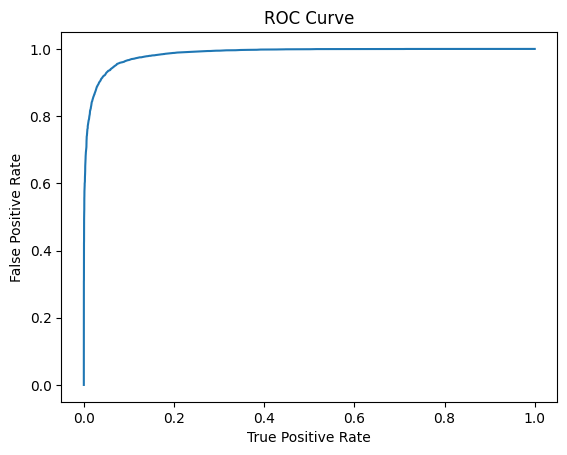

In [ ]:
#Reciever operating characteristic
trainsummary = log_reg.summary #summay of model results
roc = trainsummary.roc.toPandas()  #transform to pandas formats
plt.plot(roc['FPR'],roc['TPR'])  #plot the false positive rate, true positive rate
plt.ylabel('False Positive Rate')
plt.xlabel("True Positive Rate")
plt.title('ROC Curve')
plt.show()

In [ ]:
print('Training set area Under the curve (AUC): '+str(trainsummary.areaUnderROC))

Training set area Under the curve (AUC): 0.9860711737499517


4)Given the dataset “Superstore.xlsx”, forecast the sales of the category “Office
Supplies” by performing the tasks given below.
a. Explore the dataset to report Stationarity using Rolling plots and Statistical
Tests.
b. Determine the order of differencing, d.
c. Determine the order p for autoregressive process Αℛ(𝑝).
d. Determine the order q for moving averages 𝑀𝐴(𝑞).
e. Fit ARIMA (p, d, q) using Q.4.b, 4.c, and 4.d and report the results with
accuracy metrics.

In [ ]:
%cd D:\predictive_data_analysis

D:\predictive_data_analysis


In [ ]:
%ls

 Volume in drive D is New Volume
 Volume Serial Number is 56AD-6E33

 Directory of D:\predictive_data_analysis

06/07/2023  11:34 PM    <DIR>          .
06/07/2023  11:34 PM    <DIR>          ..
05/08/2023  03:39 PM            12,544 01-NumPy-Indexing-and-Selection.ipynb
05/08/2023  03:39 PM            11,622 02-NumPy-Operations.ipynb
05/09/2023  11:05 AM             4,440 09 May 2023- Load Data.ipynb
05/15/2023  03:28 PM             3,847 15 May 2023 Pandas-Exercises.ipynb
05/15/2023  03:21 PM            11,718 15 May 23 05-Operations.ipynb
05/16/2023  09:30 AM             8,772 15 May 23 DataFrames Practice Exercise .ipynb
05/15/2023  10:54 PM             3,386 15_may_2023.R
05/29/2023  11:32 AM             2,049 airline_passengers.csv
05/23/2023  02:47 PM            10,104 averages.xlsx
05/22/2023  12:58 PM             9,292 CONFUSION_MATRIX.xlsx
06/05/2023  11:20 AM             8,734 cruise_ship_info.csv
06/07/2023  11:18 AM           490,010 CSC620 CA1 Predictive Analytics.pdf
05/

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
store=pd.read_excel("Superstore.xls")

In [ ]:
store

Row ID        Order ID Order Date  Ship Date       Ship Mode  \
0          1  CA-2016-152156 2016-11-08 2016-11-11    Second Class   
1          2  CA-2016-152156 2016-11-08 2016-11-11    Second Class   
2          3  CA-2016-138688 2016-06-12 2016-06-16    Second Class   
3          4  US-2015-108966 2015-10-11 2015-10-18  Standard Class   
4          5  US-2015-108966 2015-10-11 2015-10-18  Standard Class   
...      ...             ...        ...        ...             ...   
9989    9990  CA-2014-110422 2014-01-21 2014-01-23    Second Class   
9990    9991  CA-2017-121258 2017-02-26 2017-03-03  Standard Class   
9991    9992  CA-2017-121258 2017-02-26 2017-03-03  Standard Class   
9992    9993  CA-2017-121258 2017-02-26 2017-03-03  Standard Class   
9993    9994  CA-2017-119914 2017-05-04 2017-05-09    Second Class   

     Customer ID     Customer Name    Segment        Country             City  \
0       CG-12520       Claire Gute   Consumer  United States        Henderson   
1       CG-12520       Claire Gute   Consumer  United States        Henderson   
2       DV-13045   Darrin Van Huff  Corporate  United States      Los Angeles   
3       SO-20335    Sean O'Donnell   Consumer  United States  Fort Lauderdale   
4       SO-20335    Sean O'Donnell   Consumer  United States  Fort Lauderdale   
...          ...               ...        ...            ...              ...   
9989    TB-21400  Tom Boeckenhauer   Consumer  United States            Miami   
9990    DB-13060       Dave Brooks   Consumer  United States       Costa Mesa   
9991    DB-13060       Dave Brooks   Consumer  United States       Costa Mesa   
9992    DB-13060       Dave Brooks   Consumer  United States       Costa Mesa   
9993    CC-12220      Chris Cortes   Consumer  United States      Westminster   

      ... Postal Code  Region       Product ID         Category Sub-Category  \
0     ...       42420   South  FUR-BO-10001798        Furniture    Bookcases   
1     ...       42420   South  FUR-CH-10000454        Furniture       Chairs   
2     ...       90036    West  OFF-LA-10000240  Office Supplies       Labels   
3     ...       33311   South  FUR-TA-10000577        Furniture       Tables   
4     ...       33311   South  OFF-ST-10000760  Office Supplies      Storage   
...   ...         ...     ...              ...              ...          ...   
9989  ...       33180   South  FUR-FU-10001889        Furniture  Furnishings   
9990  ...       92627    West  FUR-FU-10000747        Furniture  Furnishings   
9991  ...       92627    West  TEC-PH-10003645       Technology       Phones   
9992  ...       92627    West  OFF-PA-10004041  Office Supplies        Paper   
9993  ...       92683    West  OFF-AP-10002684  Office Supplies   Appliances   

                                           Product Name     Sales  Quantity  \
0                     Bush Somerset Collection Bookcase  261.9600         2   
1     Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400         3   
2     Self-Adhesive Address Labels for Typewriters b...   14.6200         2   
3         Bretford CR4500 Series Slim Rectangular Table  957.5775         5   
4                        Eldon Fold 'N Roll Cart System   22.3680         2   
...                                                 ...       ...       ...   
9989                             Ultra Door Pull Handle   25.2480         3   
9990  Tenex B1-RE Series Chair Mats for Low Pile Car...   91.9600         2   
9991                              Aastra 57i VoIP phone  258.5760         2   
9992  It's Hot Message Books with Stickers, 2 3/4" x 5"   29.6000         4   
9993  Acco 7-Outlet Masterpiece Power Center, Wihtou...  243.1600         2   

      Discount    Profit  
0         0.00   41.9136  
1         0.00  219.5820  
2         0.00    6.8714  
3         0.45 -383.0310  
4         0.20    2.5164  
...        ...       ...  
9989      0.20    4.1028  
9990      0.00   15.6332  
9991      0.20   19.3932  
9992      0.

In [ ]:
store["Category"].unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [ ]:
#categories of sales data
store.Category.value_counts()

Office Supplies    6026
Furniture          2121
Technology         1847
Name: Category, dtype: int64

In [ ]:
store.Region.value_counts()

West       3203
East       2848
Central    2323
South      1620
Name: Region, dtype: int64

In [ ]:
ofs=store.loc[store["Category"]=="Office Supplies"]
ofs

Row ID        Order ID Order Date  Ship Date       Ship Mode  \
2          3  CA-2016-138688 2016-06-12 2016-06-16    Second Class   
4          5  US-2015-108966 2015-10-11 2015-10-18  Standard Class   
6          7  CA-2014-115812 2014-06-09 2014-06-14  Standard Class   
8          9  CA-2014-115812 2014-06-09 2014-06-14  Standard Class   
9         10  CA-2014-115812 2014-06-09 2014-06-14  Standard Class   
...      ...             ...        ...        ...             ...   
9982    9983  US-2016-157728 2016-09-22 2016-09-28  Standard Class   
9984    9985  CA-2015-100251 2015-05-17 2015-05-23  Standard Class   
9985    9986  CA-2015-100251 2015-05-17 2015-05-23  Standard Class   
9992    9993  CA-2017-121258 2017-02-26 2017-03-03  Standard Class   
9993    9994  CA-2017-119914 2017-05-04 2017-05-09    Second Class   

     Customer ID     Customer Name    Segment        Country             City  \
2       DV-13045   Darrin Van Huff  Corporate  United States      Los Angeles   
4       SO-20335    Sean O'Donnell   Consumer  United States  Fort Lauderdale   
6       BH-11710   Brosina Hoffman   Consumer  United States      Los Angeles   
8       BH-11710   Brosina Hoffman   Consumer  United States      Los Angeles   
9       BH-11710   Brosina Hoffman   Consumer  United States      Los Angeles   
...          ...               ...        ...            ...              ...   
9982    RC-19960        Ryan Crowe   Consumer  United States     Grand Rapids   
9984    DV-13465  Dianna Vittorini   Consumer  United States       Long Beach   
9985    DV-13465  Dianna Vittorini   Consumer  United States       Long Beach   
9992    DB-13060       Dave Brooks   Consumer  United States       Costa Mesa   
9993    CC-12220      Chris Cortes   Consumer  United States      Westminster   

      ... Postal Code   Region       Product ID         Category Sub-Category  \
2     ...       90036     West  OFF-LA-10000240  Office Supplies       Labels   
4     ...       33311    South  OFF-ST-10000760  Office Supplies      Storage   
6     ...       90032     West  OFF-AR-10002833  Office Supplies          Art   
8     ...       90032     West  OFF-BI-10003910  Office Supplies      Binders   
9     ...       90032     West  OFF-AP-10002892  Office Supplies   Appliances   
...   ...         ...      ...              ...              ...          ...   
9982  ...       49505  Central  OFF-PA-10002195  Office Supplies        Paper   
9984  ...       11561     East  OFF-LA-10003766  Office Supplies       Labels   
9985  ...       11561     East  OFF-SU-10000898  Office Supplies     Supplies   
9992  ...       92627     West  OFF-PA-10004041  Office Supplies        Paper   
9993  ...       92683     West  OFF-AP-10002684  Office Supplies   Appliances   

                                           Product Name    Sales  Quantity  \
2     Self-Adhesive Address Labels for Typewriters b...   14.620         2   
4                        Eldon Fold 'N Roll Cart System   22.368         2   
6                                            Newell 322    7.280         4   
8     DXL Angle-View Binders with Locking Rings by S...   18.504         3   
9                      Belkin F5C206VTEL 6 Outlet Surge  114.900         5   
...                                                 ...      ...       ...   
9982  RSVP Cards & Envelopes, Blank White, 8-1/2" X ...   35.560         7   
9984                     Self-Adhesive Removable Labels   31.500        10   
9985  Acme Hot Forged Carbon Steel Scissors with Nic...   55.600         4   
9992  It's Hot Message Books with Stickers, 2 3/4" x 5"   29.600         4   
9993  Acco 7-Outlet Masterpiece Power Center, Wihtou...  243.160         2   

      Discount   Profit  
2          0.0   6.8714  
4          0.2   2.5164  
6          0.0   1.9656  
8          0.2   5.7825  
9          0.0  34.4700  
...        ...      ...  
9982       0.0  16.7132  
9984       0.0  15.1200  
9985       0.0  16.1240  
9992       0.0  13.320

In [ ]:
ofs.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [ ]:
#check if more than one sales data is there for a date
os=ofs.groupby('Order Date')["Sales"].size()

In [ ]:
os

Order Date
2014-01-03     1
2014-01-04     3
2014-01-05     1
2014-01-06     6
2014-01-07     1
              ..
2017-12-26     4
2017-12-27     1
2017-12-28    12
2017-12-29     5
2017-12-30     5
Name: Sales, Length: 1148, dtype: int64

In [ ]:
os[os>1].sort_values(ascending=False)

Order Date
2017-12-09    25
2016-11-10    25
2016-09-05    24
2017-12-02    22
2017-09-02    22
              ..
2017-06-27     2
2015-08-15     2
2017-07-02     2
2016-10-22     2
2017-03-07     2
Name: Sales, Length: 987, dtype: int64

In [ ]:
#indexing with time series dataset
os=ofs.set_index("Order Date")

In [ ]:
os

Row ID        Order ID  Ship Date       Ship Mode Customer ID  \
Order Date                                                                  
2016-06-12       3  CA-2016-138688 2016-06-16    Second Class    DV-13045   
2015-10-11       5  US-2015-108966 2015-10-18  Standard Class    SO-20335   
2014-06-09       7  CA-2014-115812 2014-06-14  Standard Class    BH-11710   
2014-06-09       9  CA-2014-115812 2014-06-14  Standard Class    BH-11710   
2014-06-09      10  CA-2014-115812 2014-06-14  Standard Class    BH-11710   
...            ...             ...        ...             ...         ...   
2016-09-22    9983  US-2016-157728 2016-09-28  Standard Class    RC-19960   
2015-05-17    9985  CA-2015-100251 2015-05-23  Standard Class    DV-13465   
2015-05-17    9986  CA-2015-100251 2015-05-23  Standard Class    DV-13465   
2017-02-26    9993  CA-2017-121258 2017-03-03  Standard Class    DB-13060   
2017-05-04    9994  CA-2017-119914 2017-05-09    Second Class    CC-12220   

               Customer Name    Segment        Country             City  \
Order Date                                                                
2016-06-12   Darrin Van Huff  Corporate  United States      Los Angeles   
2015-10-11    Sean O'Donnell   Consumer  United States  Fort Lauderdale   
2014-06-09   Brosina Hoffman   Consumer  United States      Los Angeles   
2014-06-09   Brosina Hoffman   Consumer  United States      Los Angeles   
2014-06-09   Brosina Hoffman   Consumer  United States      Los Angeles   
...                      ...        ...            ...              ...   
2016-09-22        Ryan Crowe   Consumer  United States     Grand Rapids   
2015-05-17  Dianna Vittorini   Consumer  United States       Long Beach   
2015-05-17  Dianna Vittorini   Consumer  United States       Long Beach   
2017-02-26       Dave Brooks   Consumer  United States       Costa Mesa   
2017-05-04      Chris Cortes   Consumer  United States      Westminster   

                 State  Postal Code   Region       Product ID  \
Order Date                                                      
2016-06-12  California        90036     West  OFF-LA-10000240   
2015-10-11     Florida        33311    South  OFF-ST-10000760   
2014-06-09  California        90032     West  OFF-AR-10002833   
2014-06-09  California        90032     West  OFF-BI-10003910   
2014-06-09  California        90032     West  OFF-AP-10002892   
...                ...          ...      ...              ...   
2016-09-22    Michigan        49505  Central  OFF-PA-10002195   
2015-05-17    New York        11561     East  OFF-LA-10003766   
2015-05-17    New York        11561     East  OFF-SU-10000898   
2017-02-26  California        92627     West  OFF-PA-10004041   
2017-05-04  California        92683     West  OFF-AP-10002684   

                   Category Sub-Category  \
Order Date                                 
2016-06-12  Office Supplies       Labels   
2015-10-11  Office Supplies      Storage   
2014-06-09  Office Supplies          Art   
2014-06-09  Office Supplies      Binders   
2014-06-09  Office Supplies   Appliances   
...                     ...          ...   
2016-09-22  Office Supplies        Paper   
2015-05-17  Office Supplies       Labels   
2015-05-17  Office Supplies     Supplies   
2017-02-26  Office Supplies        Paper   
2017-05-04  Office Supplies   Appliances   

                                                 Product Name    Sales  \
Order Date                                                               
2016-06-12  Self-Adhesive Address Labels for Typewriters b...   14.620   
2015-10-11                     Eldon Fold 'N Roll Cart System   22.368   
2014-06-09                                         Newell 322    7.280   
2014-06-09  DXL Angle-View Binders with Locking Rings by S...   18.504   
2014-06-09                   Belkin F5C206VTEL 6 Outlet Surge  114.900   
...                                                       ...      ...   
2016-09-22  RSVP Cards 

<Axes: xlabel='Order Date'>

<Figure size 1600x600 with 0 Axes>

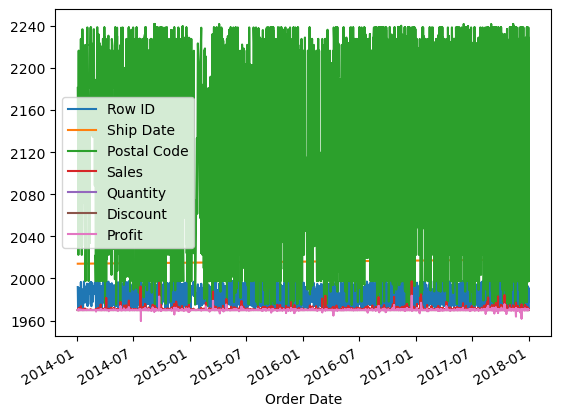

In [ ]:
plt.figure(figsize=(16,6))
os.plot()

In [ ]:
os["Year"]=pd.DatetimeIndex(os.index).year

In [ ]:
os

Row ID        Order ID  Ship Date       Ship Mode Customer ID  \
Order Date                                                                  
2016-06-12       3  CA-2016-138688 2016-06-16    Second Class    DV-13045   
2015-10-11       5  US-2015-108966 2015-10-18  Standard Class    SO-20335   
2014-06-09       7  CA-2014-115812 2014-06-14  Standard Class    BH-11710   
2014-06-09       9  CA-2014-115812 2014-06-14  Standard Class    BH-11710   
2014-06-09      10  CA-2014-115812 2014-06-14  Standard Class    BH-11710   
...            ...             ...        ...             ...         ...   
2016-09-22    9983  US-2016-157728 2016-09-28  Standard Class    RC-19960   
2015-05-17    9985  CA-2015-100251 2015-05-23  Standard Class    DV-13465   
2015-05-17    9986  CA-2015-100251 2015-05-23  Standard Class    DV-13465   
2017-02-26    9993  CA-2017-121258 2017-03-03  Standard Class    DB-13060   
2017-05-04    9994  CA-2017-119914 2017-05-09    Second Class    CC-12220   

               Customer Name    Segment        Country             City  \
Order Date                                                                
2016-06-12   Darrin Van Huff  Corporate  United States      Los Angeles   
2015-10-11    Sean O'Donnell   Consumer  United States  Fort Lauderdale   
2014-06-09   Brosina Hoffman   Consumer  United States      Los Angeles   
2014-06-09   Brosina Hoffman   Consumer  United States      Los Angeles   
2014-06-09   Brosina Hoffman   Consumer  United States      Los Angeles   
...                      ...        ...            ...              ...   
2016-09-22        Ryan Crowe   Consumer  United States     Grand Rapids   
2015-05-17  Dianna Vittorini   Consumer  United States       Long Beach   
2015-05-17  Dianna Vittorini   Consumer  United States       Long Beach   
2017-02-26       Dave Brooks   Consumer  United States       Costa Mesa   
2017-05-04      Chris Cortes   Consumer  United States      Westminster   

                 State  ...   Region       Product ID         Category  \
Order Date              ...                                              
2016-06-12  California  ...     West  OFF-LA-10000240  Office Supplies   
2015-10-11     Florida  ...    South  OFF-ST-10000760  Office Supplies   
2014-06-09  California  ...     West  OFF-AR-10002833  Office Supplies   
2014-06-09  California  ...     West  OFF-BI-10003910  Office Supplies   
2014-06-09  California  ...     West  OFF-AP-10002892  Office Supplies   
...                ...  ...      ...              ...              ...   
2016-09-22    Michigan  ...  Central  OFF-PA-10002195  Office Supplies   
2015-05-17    New York  ...     East  OFF-LA-10003766  Office Supplies   
2015-05-17    New York  ...     East  OFF-SU-10000898  Office Supplies   
2017-02-26  California  ...     West  OFF-PA-10004041  Office Supplies   
2017-05-04  California  ...     West  OFF-AP-10002684  Office Supplies   

           Sub-Category                                       Product Name  \
Order Date                                                                   
2016-06-12       Labels  Self-Adhesive Address Labels for Typewriters b...   
2015-10-11      Storage                     Eldon Fold 'N Roll Cart System   
2014-06-09          Art                                         Newell 322   
2014-06-09      Binders  DXL Angle-View Binders with Locking Rings by S...   
2014-06-09   Appliances                   Belkin F5C206VTEL 6 Outlet Surge   
...                 ...                                                ...   
2016-09-22        Paper  RSVP Cards & Envelopes, Blank White, 8-1/2" X ...   
2015-05-17       Labels                     Self-Adhesive Removable Labels   
2015-05-17     Supplies  Acme Hot Forged Carbon Steel Scissors with Nic...   
2017-02-26        Paper  It's Hot Message Books with Stickers, 2 3/4" x 5"   
2017-05-04   Appliances  Acco 7-Outlet Masterpiece Power Center, Wihtou...   

              Sales  Quantity  Discount   Profit  Year  

In [ ]:
os["Month"]=pd.DatetimeIndex(os.index).month
os["Day"]=pd.DatetimeIndex(os.index).day

<Axes: xlabel='Order Date'>

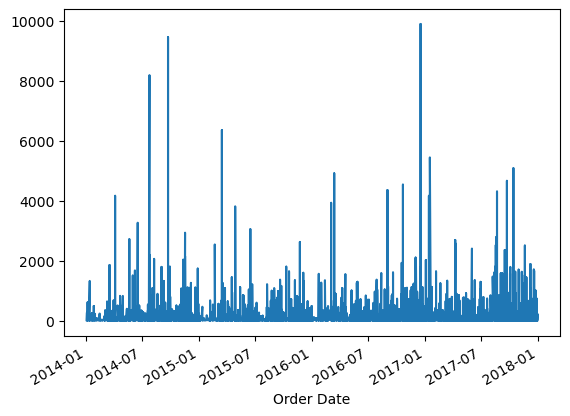

In [ ]:
os["Sales"].plot()

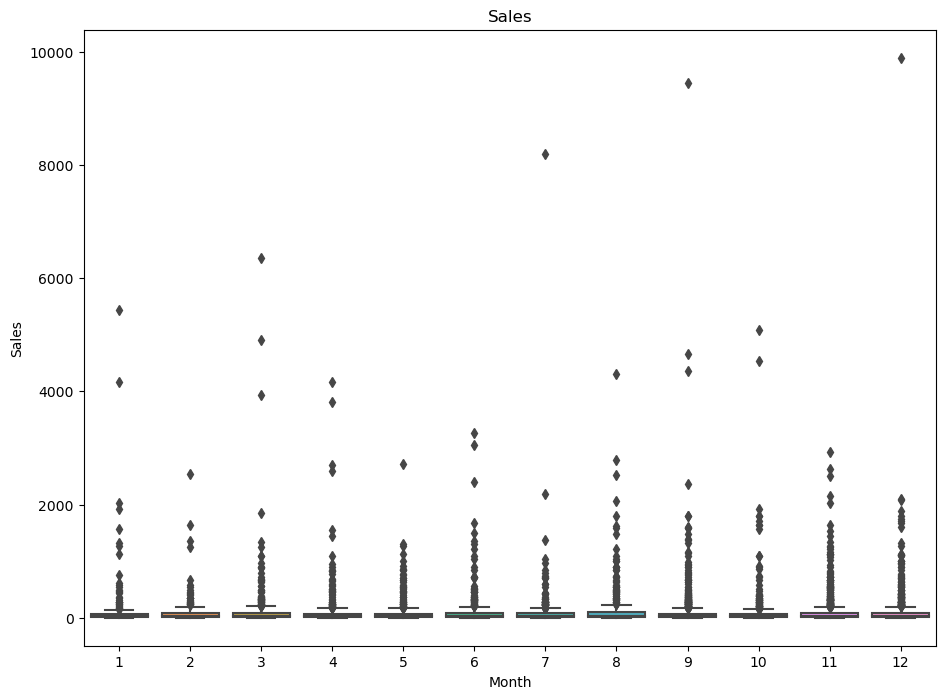

In [ ]:
import seaborn as sns
#to check the seasoning it by month
fig,ax=plt.subplots(figsize=(11,8))
sns.boxplot(data=os,x="Month",y="Sales",ax=ax)
ax.set_title("Sales")
ax.set_label("Daily consolidated sales")

<Axes: xlabel='Order Date'>

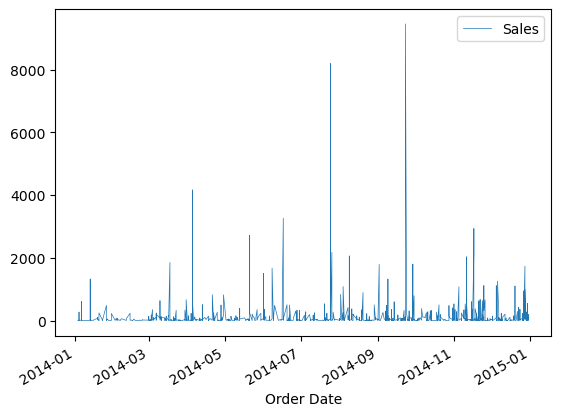

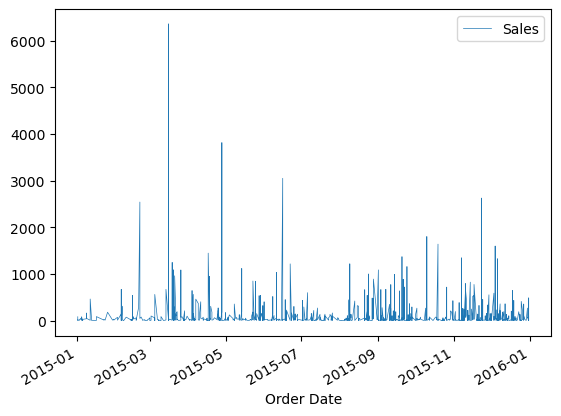

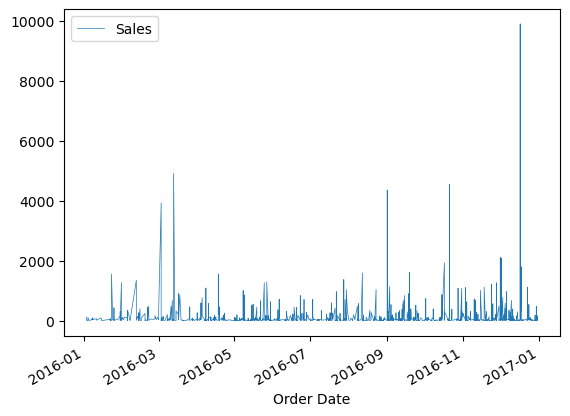

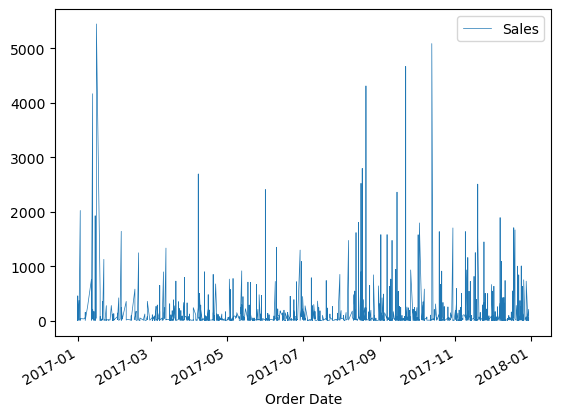

In [ ]:
cols_plot=['Sales']
os.loc['2014'][cols_plot].plot(linewidth=0.5)
os.loc['2015'][cols_plot].plot(linewidth=0.5)
os.loc['2016'][cols_plot].plot(linewidth=0.5)
os.loc['2017'][cols_plot].plot(linewidth=0.5)

In [ ]:
#monthly sales
data_columns=["Sales"]
os_week=os[data_columns].resample("W").sum()
os_week.head()

Sales
Order Date          
2014-01-05   324.044
2014-01-12   708.004
2014-01-19  2337.764
2014-01-26  1143.170
2014-02-02   368.784

<Axes: xlabel='Order Date'>

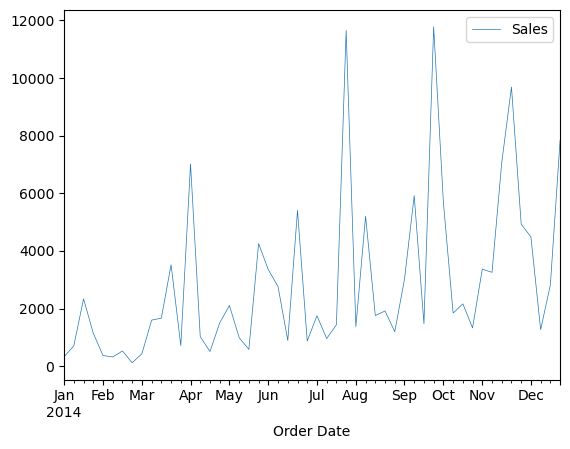

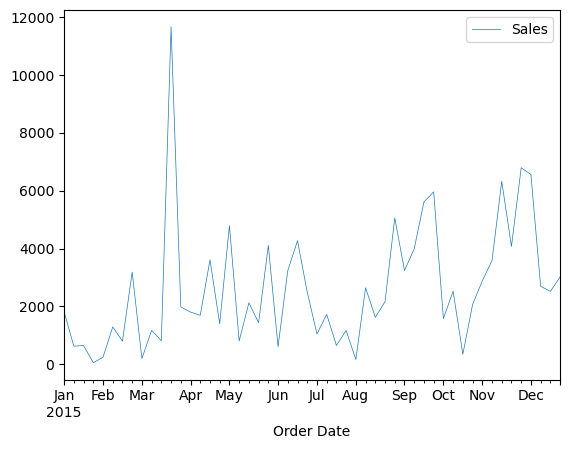

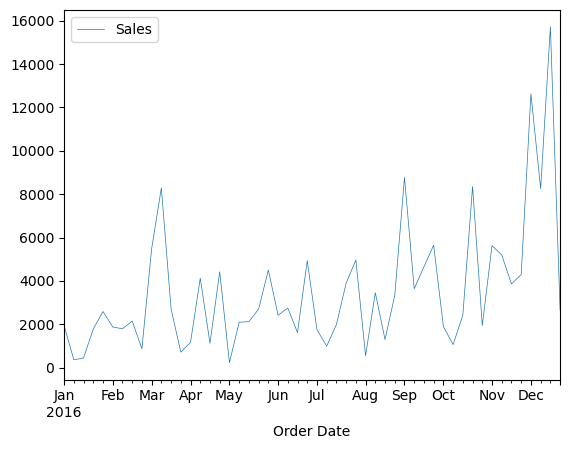

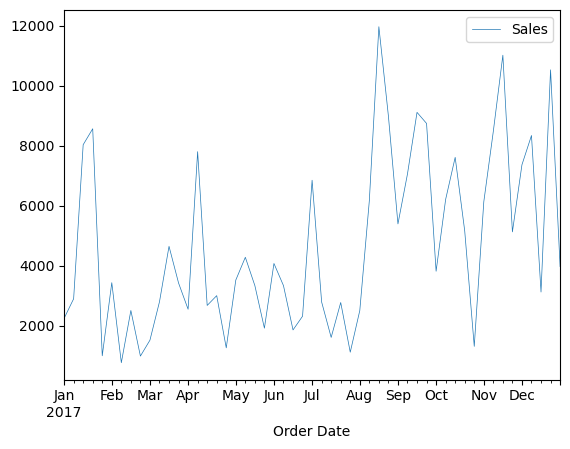

In [ ]:
cols_plot=['Sales']
os_week.loc['2014'][cols_plot].plot(linewidth=0.5)
os_week.loc['2015'][cols_plot].plot(linewidth=0.5)
os_week.loc['2016'][cols_plot].plot(linewidth=0.5)
os_week.loc['2017'][cols_plot].plot(linewidth=0.5)

In [ ]:
#monthly sales
data_colums=['Sales']
os_month=os[data_colums].resample('M').sum()
os_month.head()

Sales
Order Date           
2014-01-31   4851.080
2014-02-28   1071.724
2014-03-31   8605.879
2014-04-30  11155.074
2014-05-31   7135.624

<Axes: xlabel='Order Date'>

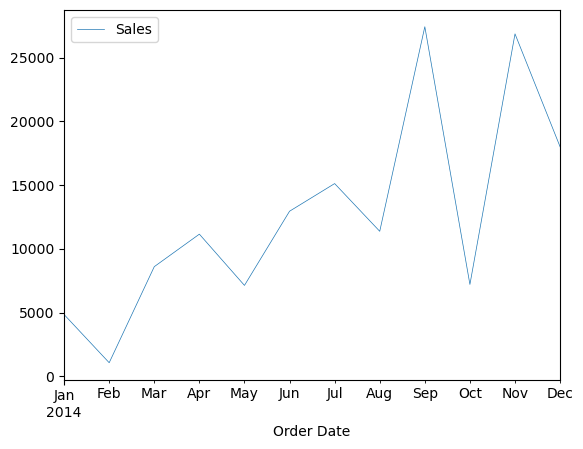

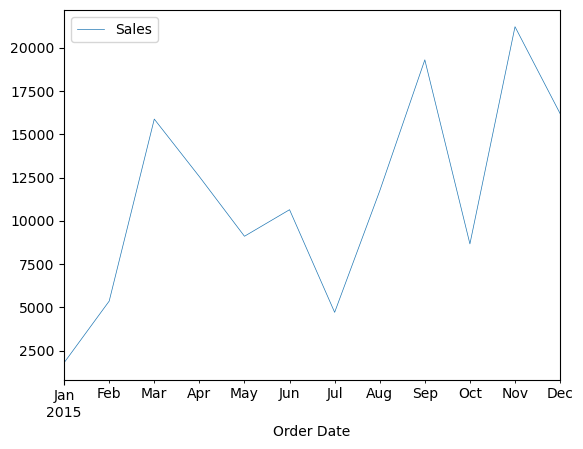

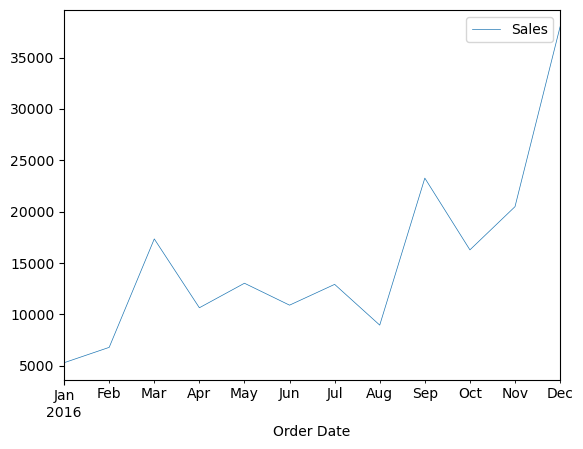

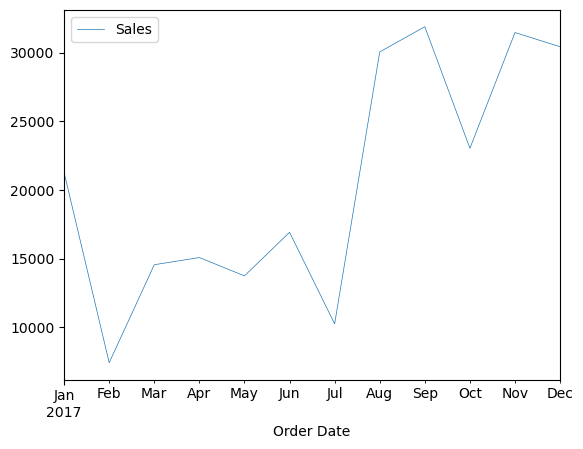

In [ ]:
cols_plot=['Sales']
os_month.loc['2014'][cols_plot].plot(linewidth=0.5)
os_month.loc['2015'][cols_plot].plot(linewidth=0.5)
os_month.loc['2016'][cols_plot].plot(linewidth=0.5)
os_month.loc['2017'][cols_plot].plot(linewidth=0.5)

#Observation
every year there is a slight uptrend visible in month of jun_dec


In [ ]:
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

In [ ]:
for year in np.unique(os.Year):
    #detect_trend(data_grouped.loc[str(year)]['Sales'].values)

    X = os.loc[str(year)]['Sales'].values

    result = adfuller(X)

    print('\nFor the year : ', year)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')

    for key, value in result[4].items():
        print('\t%5s: %8.3f' % (key, value))

X = os['Sales'].values

result = adfuller(X)

print('\nFor the CONSOLIDATED 4 years')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%5s: %8.3f' % (key, value))


For the year :  2014
ADF Statistic: -34.597069
p-value: 0.000000
Critical Values:
	   1%:   -3.436
	   5%:   -2.864
	  10%:   -2.568

For the year :  2015
ADF Statistic: -34.945148
p-value: 0.000000
Critical Values:
	   1%:   -3.436
	   5%:   -2.864
	  10%:   -2.568

For the year :  2016
ADF Statistic: -40.063922
p-value: 0.000000
Critical Values:
	   1%:   -3.435
	   5%:   -2.863
	  10%:   -2.568

For the year :  2017
ADF Statistic: -43.904775
p-value: 0.000000
Critical Values:
	   1%:   -3.434
	   5%:   -2.863
	  10%:   -2.568

For the CONSOLIDATED 4 years
ADF Statistic: -77.718121
p-value: 0.000000
Critical Values:
	   1%:   -3.431
	   5%:   -2.862
	  10%:   -2.567
